# 🎉 Out-of-Distribution (OOD) with PCA using Deep Features from the Latent Space

The goal of this notebook is to understand the depths of using Principal Component Analysis in order to perform OOD tasks using deep features from the latent space

## 📝 Plan of action

### ♻️ Preprocessing phase

In order to achieve our goal, we need to understand how the dataset is structured.

For this notebook, we are going to use the CBIR 15 dataset, that contains images of different places, such as an office, a bedroom, a mountain, etc. Note that there are some places that are similar one to another, i.e. a bedroom and a living room.

Thus, in order to extract the features of the images we have to preprocess those images:

- Get the images that are located in data/CBIR_15-scene and fit them to a dataframe using Pandas
  - Locate the "Labels.txt" file: it shows where the indexes of the images from each category starts
- Create the dataset with this information with two columns: the path to the image and its category
- Transform all of the images in the same size (in this case, we are going with 256x256)
  
Now, in order to extract the features, it's necessary to divide the reshaped images into patches of 32x32 pixels. This is good to perform processing tasks to avoid waiting long periods of time.

After all the preprocess, we should separate the images into two different foldes: one contains the patches of the training images that is going to give us their principal components and dimensions, and the other is the patches of the test images, that is going to be tested to fit into those dimensions and we'll get an OOD score afterwards.

### 🏋🏽‍♂️ Training phase

With the images that are stored inside the "patches_train" folder, the first thing we are going to do is _normalize_ all of the images to find the correct maximum covariance and transforming all the variables into the same scale.

Next, we should then apply the PCA with all the components. As we have patches of 32x32, we'll be having 1024 features, hence components. Then we plot a graph to see how many components truly contributes for the most variance of the data - and give us more information about it. We're going to take the threshold of 95% of variance in this notebook.

After getting the PCA with components that describe 95% of the variance, it's time to test our images and see how far of the residual space their data can be found.

### ⚗️ Test phase and results

In this phase, we take the test images and normalize then with the same scale of each PCA. This is important to maintain consistency throughout the final results and measure the norms in the new dimension properly.

After that, we calculate the norm of the projection of the given data into the orthogonal space of the principal component and divide it by the norm of the data in relation to the origin. This is the OOD score.

We calculate the mean of the score for each category and get the minimal one. The current environment is the smallest.


--------------------------

First of all, we need to understand which libraries we are going to use:

- os: Deals with the operation system interface such as finding the relative and absolute path of files inside a project and reading/writing files for example.
- sys: This module provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter.
- numpy: NumPy is the fundamental package for scientific computing in Python. It is a Python library that provides a multidimensional array object, various derived objects (such as masked arrays and matrices), and an assortment of routines for fast operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, discrete Fourier transforms, basic linear algebra, basic statistical operations, random simulation and much more.
- pandas: Pandas is an open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.
- matplotlib: Deals with plotting graphs to visualize data in a graphical way.
- sklearn: Scikit-learn provides dozens of built-in machine learning algorithms and models, called estimators.

In [1]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [5]:
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("OpenCV version:", cv2.__version__)


NumPy version: 1.24.3
Pandas version: 2.2.2
OpenCV version: 4.10.0


I'd suggest to use a conda virtual environment in order to avoid messing up your base kernel environment and causing dependency errors in the future.

After you successfully installed all the modules, it's time to import our custom modules that are going to deal with:

- Creation of our dataframe using pandas
- Separation of our dataset into patches of 32x32 in folders of training and test

In [6]:

sys.path.append(os.path.abspath('..'))

from dataframe_generator import *
from images_standardizing import *

In [7]:
import tarfile

def extract_tgz(tgz_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    
    with tarfile.open(tgz_path, 'r:gz') as tar:
        tar.extractall(path=extract_to)
        print(f"Arquivos extraídos para {extract_to}")

tgz_path = '../CBIR_15-Scene.tgz'
extract_to = '../data/'

extract_tgz(tgz_path, extract_to)

Arquivos extraídos para ../data/


In [8]:
df = create_dataframe()
df

                             image_path category
0        ../data/CBIR_15-Scene/00/1.jpg  Bedroom
1        ../data/CBIR_15-Scene/00/2.jpg  Bedroom
2        ../data/CBIR_15-Scene/00/3.jpg  Bedroom
3        ../data/CBIR_15-Scene/00/4.jpg  Bedroom
4        ../data/CBIR_15-Scene/00/5.jpg  Bedroom
...                                 ...      ...
4480  ../data/CBIR_15-Scene/14/4481.jpg    Store
4481  ../data/CBIR_15-Scene/14/4482.jpg    Store
4482  ../data/CBIR_15-Scene/14/4483.jpg    Store
4483  ../data/CBIR_15-Scene/14/4484.jpg    Store
4484  ../data/CBIR_15-Scene/14/4485.jpg    Store

[4485 rows x 2 columns]


,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
4480,../data/CBIR_15-Scene/14/4481.jpg,Store
4481,../data/CBIR_15-Scene/14/4482.jpg,Store
4482,../data/CBIR_15-Scene/14/4483.jpg,Store
4483,../data/CBIR_15-Scene/14/4484.jpg,Store


## ☝️ Part I: Comparing two different environments

### ♻️ Preprocessing phase

Now we start our experiments to understand if our idea work, however this time we are going to understand what happens with our approach using two different environments.

In our case, I'm going to take the **Coast** and **Office** environments arbitrarily.


In [9]:
train_categories = ['Coast', 'Office']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
1267,../data/CBIR_15-Scene/05/1268.jpg,Coast
1268,../data/CBIR_15-Scene/05/1269.jpg,Coast
1269,../data/CBIR_15-Scene/05/1270.jpg,Coast
1270,../data/CBIR_15-Scene/05/1271.jpg,Coast
1271,../data/CBIR_15-Scene/05/1272.jpg,Coast
...,...,...
4165,../data/CBIR_15-Scene/13/4166.jpg,Office
4166,../data/CBIR_15-Scene/13/4167.jpg,Office
4167,../data/CBIR_15-Scene/13/4168.jpg,Office
4168,../data/CBIR_15-Scene/13/4169.jpg,Office


It's time to separate our dataset into train and test. We should use the built-in function of sklearn to do this:

In [10]:
X = df_different['image_path'].tolist()
y = df_different['category'].tolist()
unique_categories = list(df_different['category'].unique())
print(f"Unique categories: {unique_categories}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

standard_size = (224, 224)

Unique categories: ['Coast', 'Office']


Making sure that everything went well, we plot the grid of all the patches from the first image of our training set

This is exactly what the module that's inside our "image_patching.py" do. So we now, need to save everything into the subfolders by calling that function:

In [11]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

Now, we should load our patches for training:

In [12]:
#training_images_by_category = load_images_by_category('images_train', y, image_size=(224, 224))
training_images_by_category = load_images_by_category('images_train', unique_categories, image_size=(224, 224))


In [23]:
def center_images(images):
    # Calcular a média ao longo do eixo dos pixels
    # Check if images have 3 or 4 dimensions
    if len(images.shape) == 3:
        num_images, height, width = images.shape
        # For grayscale images, no need for the 'channels' dimension
        mean_image = np.mean(images, axis=(1, 2), keepdims=True)
    elif len(images.shape) == 4:
        num_images, height, width, channels = images.shape
        mean_image = np.mean(images, axis=(1, 2, 3), keepdims=True)
    else:
        raise ValueError("Unexpected image shape")

    # Subtract the mean from each image
    centered_images = images - mean_image
    
    return centered_images

centered_images_by_category = {}
for category, images in training_images_by_category.items():
    print(images.shape)
    centered_images = center_images(images)
    centered_images_by_category[category] = centered_images
    print(f"Category {category}, images shape: {centered_images.shape}")

(288, 224, 224)
Category Coast, images shape: (288, 224, 224)
(172, 224, 224)
Category Office, images shape: (172, 224, 224)


### 🏋🏽‍♂️ Training phase

Now that the have our training patches stored in that variable above, we should start our analysis with PCA.

First of all, we **need to normalize and center** the data. It's so importantt that I had to emphasize it. Plus, since we are dealing with different categories, each one of them should be normalized with a different scaler (and we're going to save it for later).

In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

In [26]:
from tensorflow.keras.applications import VGG16

# Carregar o modelo VGG16 com os pesos pré-treinados no ImageNet
base_model = VGG16(weights='imagenet', include_top=True)

# Ver o resumo do modelo
base_model.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [27]:
# Getting the before last layer (Fully connected)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

In [28]:
preprocessed_images_by_category = centered_images_by_category 


In [29]:
import numpy as np

def convert_grayscale_to_rgb(images):
    return np.stack((images,) * 3, axis=-1)

features_by_category = {}
for category, images in preprocessed_images_by_category.items():
    # Garantir que as imagens sejam um array NumPy
    images = np.array(images)

    # Verifica se a imagem está em grayscale
    if images.shape[-1] != 3:
        images = convert_grayscale_to_rgb(images)

    # Adicionar uma dimensão de lote se necessário
    if len(images.shape) == 3:  # Caso seja uma única imagem
        images = np.expand_dims(images, axis=0)

    # Garantir que as imagens estão no formato float32
    images = images.astype(np.float32)

    # Imprimir forma e tipo dos dados antes da predição
    print(f"Categoria: {category}, Forma das imagens: {images.shape}, Tipo: {images.dtype}")

    # Fazer a predição
    try:
        features = model.predict(images)
        features_by_category[category] = features
    except Exception as e:
        print(f"Erro ao predizer categoria {category}: {e}")

# Verificar as features geradas
for category, features in features_by_category.items():
    print(f"Category {category}, features shape: {features.shape}")


Categoria: Coast, Forma das imagens: (288, 224, 224, 3), Tipo: float32
9/9 [==============================] - 19s 2s/step
Categoria: Office, Forma das imagens: (172, 224, 224, 3), Tipo: float32
6/6 [==============================] - 12s 2s/step
Category Coast, features shape: (288, 4096)
Category Office, features shape: (172, 4096)


In [30]:
pca_by_category = {}
explained_variance_by_category = {}

for category, features in features_by_category.items():
    pca = PCA(n_components=0.95)  
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, principal components: {principal_components.shape[1]}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, principal components shape: {pca.components_.shape}")
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")


Category Coast, principal components: 148
Category Office, principal components: 118
Category Coast, principal components shape: (148, 4096)
Category Coast, explained variance: 95.05%
Category Office, principal components shape: (118, 4096)
Category Office, explained variance: 95.11%


### Testing phase


In [31]:
def load_and_preprocess_test_images(test_dir, categories, image_size, input_size):
    test_images_by_category = load_images_by_category(test_dir, categories, image_size)
    test_centered_images_by_category = {}
    test_scalers_by_category = {}

    for category, images in test_images_by_category.items():
        test_centered_images = center_images(images)
        test_centered_images_by_category[category] = test_centered_images

    return test_centered_images_by_category

image_size = (224, 224)

test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size=(224,224))


In [32]:
import numpy as np

def ensure_rgb_format(images):
    # Verifique se as imagens têm três dimensões (batch_size, height, width)
    if len(images.shape) == 3:  
        # Se for grayscale, expanda a dimensão para criar imagens com 3 canais (RGB)
        images = np.stack((images,) * 3, axis=-1)
    return images

def extract_features_with_vgg16(model, preprocessed_images_by_category):
    features_by_category = {}
    for category, images in preprocessed_images_by_category.items():
        # Garanta que as imagens estão no formato RGB correto
        images = ensure_rgb_format(images)
        
        # Realize a predição com o modelo
        features = model.predict(images)
        features_by_category[category] = features
    return features_by_category

# Agora extraia as características usando o modelo
test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_images_by_category)


2/2 [==============================] - 3s 677ms/step


In [33]:
def centralize_features(features_by_category):
    centralized_features_by_category = {}
    for category, features in features_by_category.items():
        # Centralize as features subtraindo a média
        mean_features = np.mean(features, axis=0)
        centralized_features = features - mean_features
        centralized_features_by_category[category] = centralized_features
        
        print(f"Category {category}: centralized features shape = {centralized_features.shape}")
        print(f"Category {category}: mean of centralized features = {np.mean(centralized_features, axis=0)}")  # Deve estar próximo de 0
    return centralized_features_by_category

centralized_test_features_by_category = centralize_features(test_features_by_category)

Category Coast: centralized features shape = (72, 4096)
Category Coast: mean of centralized features = [-5.1740141e-09 -6.5399540e-08 -1.4901161e-08 ...  7.4505806e-08
 -1.0016892e-07  7.8645019e-09]
Category Office: centralized features shape = (43, 4096)
Category Office: mean of centralized features = [ 2.3564628e-08  6.2376952e-09 -1.8713086e-08 ...  6.2376952e-09
 -8.6634658e-11  1.3861546e-08]


In [34]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in centralized_test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Coast
Category Coast, mean reconstruction error: 0.07593158632516861
Category Office, mean reconstruction error: 0.11962752789258957
Best category: Coast
Test category: Office
Category Coast, mean reconstruction error: 0.1520795226097107
Category Office, mean reconstruction error: 0.11885131895542145
Best category: Office


## Agnostic Spaces Analsys

In [35]:
from sklearn.decomposition import PCA
import numpy as np

# Inicializar o dicionário para armazenar os resultados de PCA
pca_results = {}

# Lista de percentuais de variância explicada para os quais você quer calcular
percentages = [95]
categories = ['Coast', 'Office']

# Loop através de diferentes percentuais de variância explicada
for perc in percentages:
    # Inicializar dicionários para armazenar os resultados
    pca_by_category = {}
    explained_variance_by_category = {}

    # Loop através de categorias
    for category, features in features_by_category.items():
        # Inicializar PCA com a porcentagem especificada
        pca = PCA(n_components=perc / 100.0)
        principal_components = pca.fit_transform(features)
        
        # Armazenar os resultados do PCA para cada categoria
        pca_by_category[category] = pca
        explained_variance_by_category[category] = pca.explained_variance_ratio_
        
        print(f"Category {category}, principal components: {principal_components.shape[1]}")

    # Armazenar resultados no dicionário principal pca_results
    pca_results[perc] = {}
    for category in categories:
        if category in pca_by_category:
            pca = pca_by_category[category]
            components = pca.components_
            explained_variance_ratio = pca.explained_variance_ratio_
            
            # Armazenar os componentes, a variância explicada e o objeto PCA
            pca_results[perc][category] = {
                'components': components,
                'explained_variance_ratio': explained_variance_ratio,
                'pca_object': pca
            }
            
            print(f"Category {category}, principal components shape: {components.shape}")
            print(f"Category {category}, explained variance: {np.sum(explained_variance_ratio) * 100:.2f}%")
        else:
            print(f"Categoria '{category}' não está presente nos dados para {perc}%.")


Category Coast, principal components: 148
Category Office, principal components: 118
Category Coast, principal components shape: (148, 4096)
Category Coast, explained variance: 95.05%
Category Office, principal components shape: (118, 4096)
Category Office, explained variance: 95.11%


In [36]:
def plot_cumulative_variance(explained_variance_ratio):
    """
    Plota a variância explicada acumulada com base na variância explicada de cada componente principal.
    
    Parameters:
    - explained_variance_ratio: Array ou lista contendo a variância explicada por componente.
    """
    cumulative_variance = np.cumsum(explained_variance_ratio)  # Calcula a variância acumulada

    plt.figure(figsize=(8, 5))
    plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--', color='b')
    plt.title('Cumulative Explained Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.grid(True)
    plt.show()

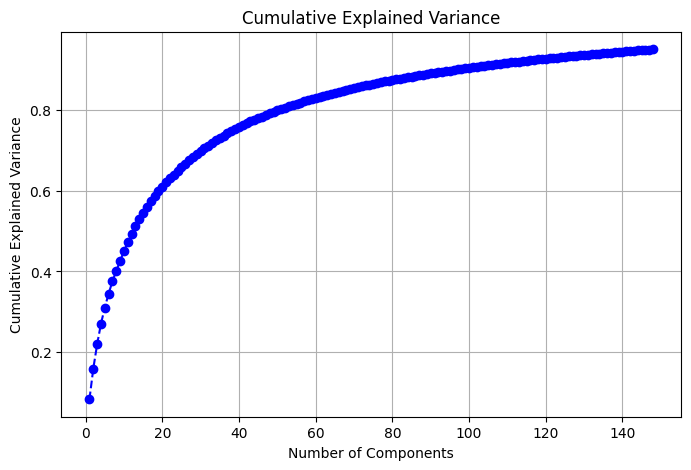

In [37]:
# Verificar se a estrutura de pca_results contém a variância explicada
percentage_to_use = 95  # Escolha a porcentagem que deseja usar
category_to_use = 'Coast'  # Escolha a categoria para analisar

if percentage_to_use in pca_results:
    if category_to_use in pca_results[percentage_to_use]:
        explained_variance_ratio = pca_results[percentage_to_use][category_to_use].get('explained_variance_ratio', None)
        
        if explained_variance_ratio is not None:
            plot_cumulative_variance(explained_variance_ratio)
        else:
            print(f"Explained variance ratio not found for {category_to_use} at {percentage_to_use}%.")
    else:
        print(f"Category '{category_to_use}' not found for {percentage_to_use}%.")
else:
    print(f"Percentage '{percentage_to_use}%' not found in pca_results.")


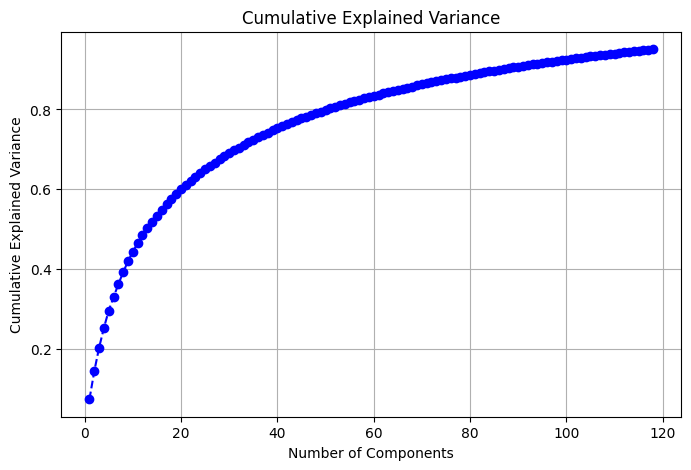

In [38]:
# Verificar se a estrutura de pca_results contém a variância explicada
percentage_to_use = 95  # Escolha a porcentagem que deseja usar
category_to_use = 'Office'  # Escolha a categoria para analisar

if percentage_to_use in pca_results:
    if category_to_use in pca_results[percentage_to_use]:
        explained_variance_ratio = pca_results[percentage_to_use][category_to_use].get('explained_variance_ratio', None)
        
        if explained_variance_ratio is not None:
            plot_cumulative_variance(explained_variance_ratio)
        else:
            print(f"Explained variance ratio not found for {category_to_use} at {percentage_to_use}%.")
    else:
        print(f"Category '{category_to_use}' not found for {percentage_to_use}%.")
else:
    print(f"Percentage '{percentage_to_use}%' not found in pca_results.")



Category: Coast on Coast (Intra-Category), Percentage: 95%


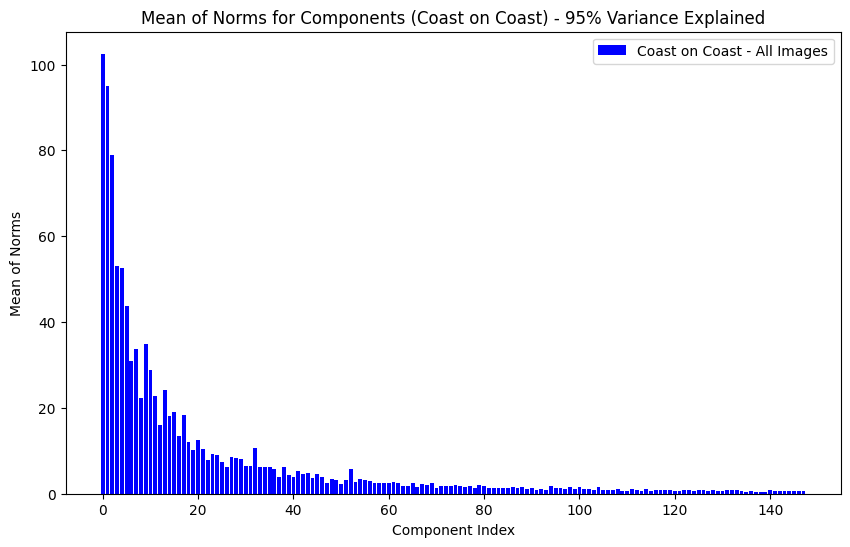


Category: Coast on Office (Cross-Category), Percentage: 95%


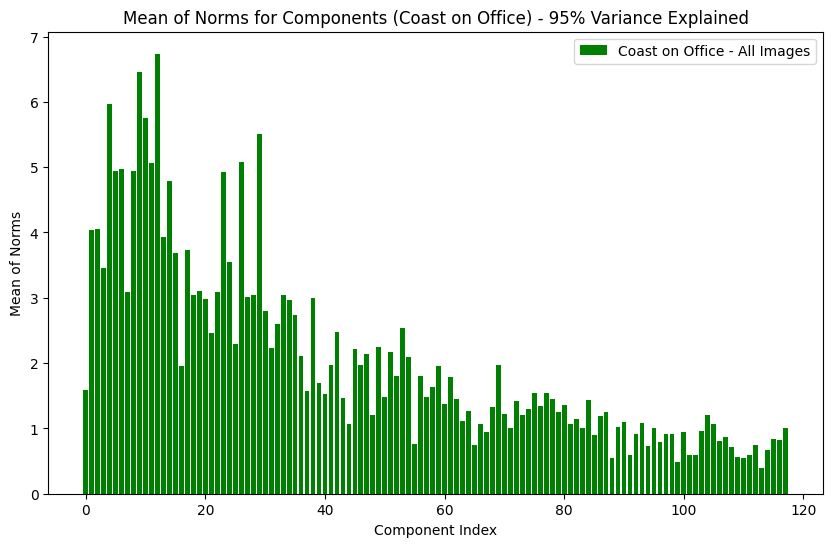


Category: Office on Coast (Cross-Category), Percentage: 95%


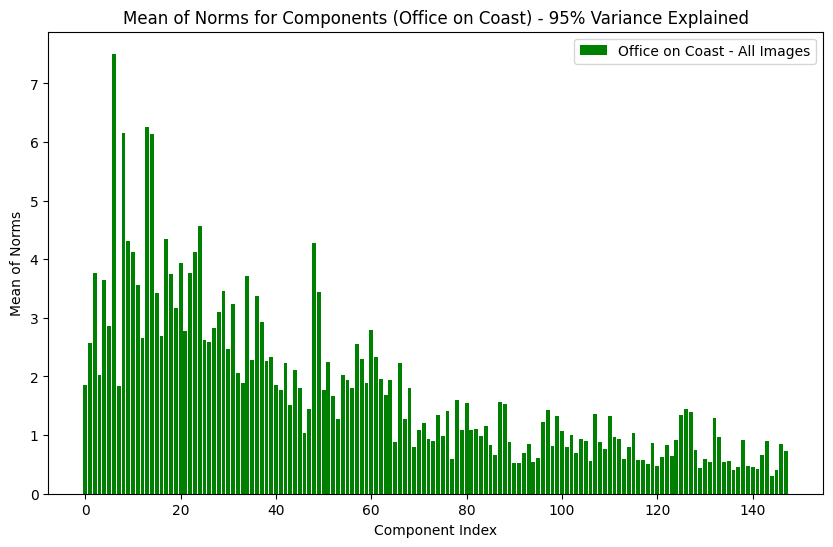


Category: Office on Office (Intra-Category), Percentage: 95%


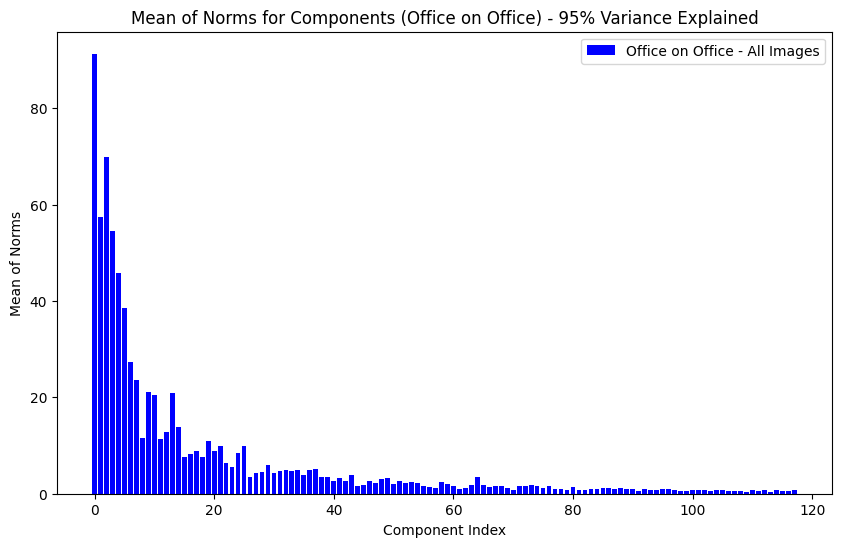

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Função para projetar patches nos componentes de uma categoria
def project_test_patches(patches, pca_components):
    # Certifique-se de que patches tem pelo menos 2 dimensões
    if len(patches.shape) == 1:
        patches = np.expand_dims(patches, axis=0)  # Expande para (1, n_features)
    
    return np.dot(patches, pca_components.T)

# Função para calcular normas, médias e médias das normas dos produtos internos no mesmo componente
def calculate_norms_and_means(projections_A, projections_B):
    norms = []
    means = []
    means_norms = []

    # Verificar se projections_A e projections_B têm pelo menos duas dimensões
    if len(projections_A.shape) < 2 or len(projections_B.shape) < 2:
        raise ValueError("Projections must have at least two dimensions (patches, components).")

    for i in range(projections_A.shape[1]):  # Itera sobre os componentes
        dot_products = np.dot(projections_A[:, i], projections_B[:, i].T)
        norms.append(np.linalg.norm(dot_products))
        means.append(np.mean(dot_products))
        means_norms.append(np.mean(np.linalg.norm(dot_products)))
        
    return norms, means, means_norms

# Função para plotar as normas médias para todas as imagens combinadas
def plot_mean_norms_for_all_images(category, other_category, mean_of_means_norms, color='blue'):
    plt.figure(figsize=(10, 6))
    
    # Plotar os resultados para todos os componentes combinados em todas as imagens
    plt.bar(range(len(mean_of_means_norms)), mean_of_means_norms, color=color,
            label=f'{category} on {other_category} - All Images')
    
    plt.title(f'Mean of Norms for Components ({category} on {other_category}) - 95% Variance Explained')
    plt.xlabel('Component Index')
    plt.ylabel('Mean of Norms')
    plt.legend()
    plt.show()

# Lista de categorias para iterar
categories = ['Coast', 'Office']

# Trabalhando apenas com o PCA de 95% de variância explicada
perc = 95

# Iterar sobre as categorias para calcular tanto intra-categories quanto cross-categories
for category in categories:
    for other_category in categories:
        # Carregar os componentes da própria categoria ou da outra categoria
        components = pca_results[perc][other_category]['components']
        
        if category == other_category:
            print(f"\nCategory: {category} on {category} (Intra-Category), Percentage: {perc}%")
            color = 'blue'
        else:
            print(f"\nCategory: {category} on {other_category} (Cross-Category), Percentage: {perc}%")
            color = 'green'
        
        # Armazenar as normas médias para todas as imagens
        all_means_norms = []
        
        # Projeção dos patches (intra ou cross-categoria) para todas as imagens
        # Itera sobre cada imagem no array de features
        for image_idx in range(centralized_test_features_by_category[category].shape[0]):
            patches = centralized_test_features_by_category[category][image_idx]  # Seleciona os patches da imagem

            # Projeta os patches nos componentes
            projected_patches = project_test_patches(patches, components)
            
            # Verifique a forma de projected_patches
            if len(projected_patches.shape) < 2 or projected_patches.shape[1] != components.shape[0]:
                raise ValueError(f"Projected patches have unexpected shape: {projected_patches.shape}. Expected at least 2 dimensions and components matching PCA.")
            
            # Calcular normas, médias e médias das normas para cada imagem
            _, _, means_norms_category = calculate_norms_and_means(projected_patches, projected_patches)
            
            # Armazenar as normas calculadas para a imagem
            all_means_norms.append(means_norms_category)
        
        # Calcular a média das normas para todas as imagens
        mean_of_means_norms = np.mean(all_means_norms, axis=0)  # Média das normas em todas as imagens
        
        # Plotar os valores médios das normas para todos os componentes combinados
        plot_mean_norms_for_all_images(category, other_category, mean_of_means_norms, color=color)



Category: Coast on Coast (Intra-Category), Percentage: 95%


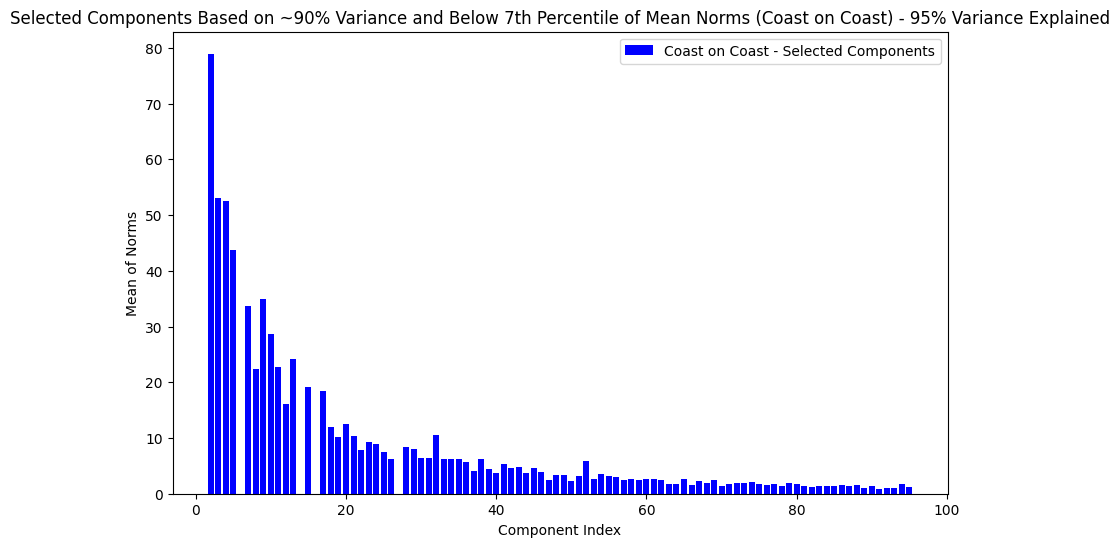


Category: Coast on Office (Cross-Category), Percentage: 95%


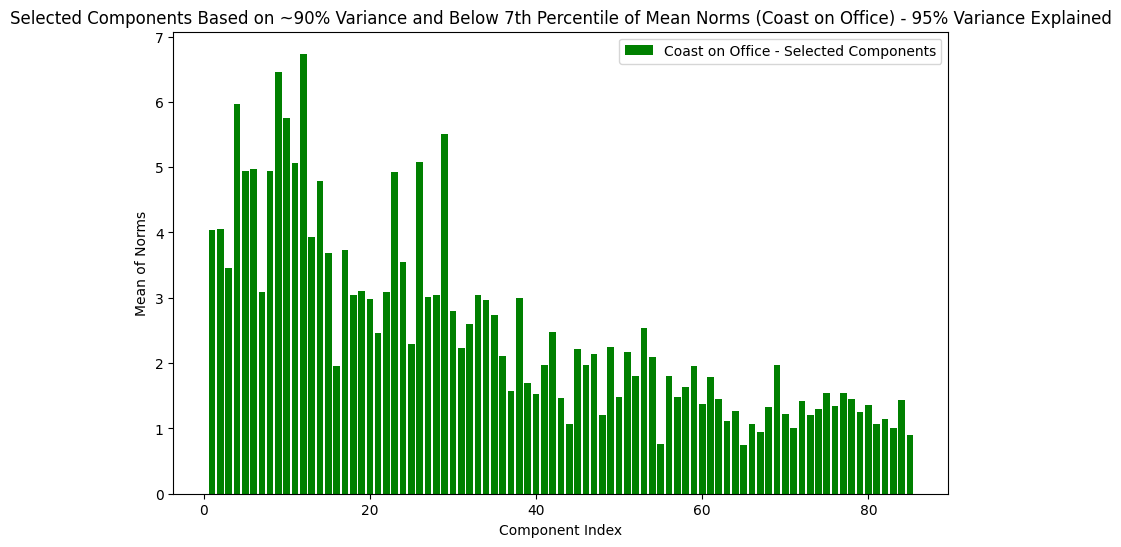


Category: Office on Coast (Cross-Category), Percentage: 95%


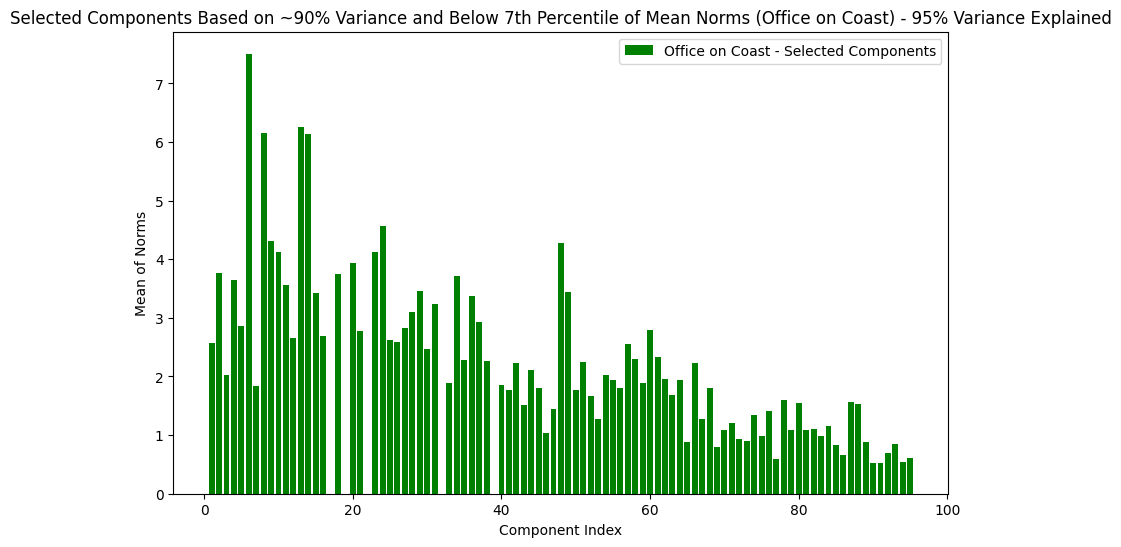


Category: Office on Office (Intra-Category), Percentage: 95%


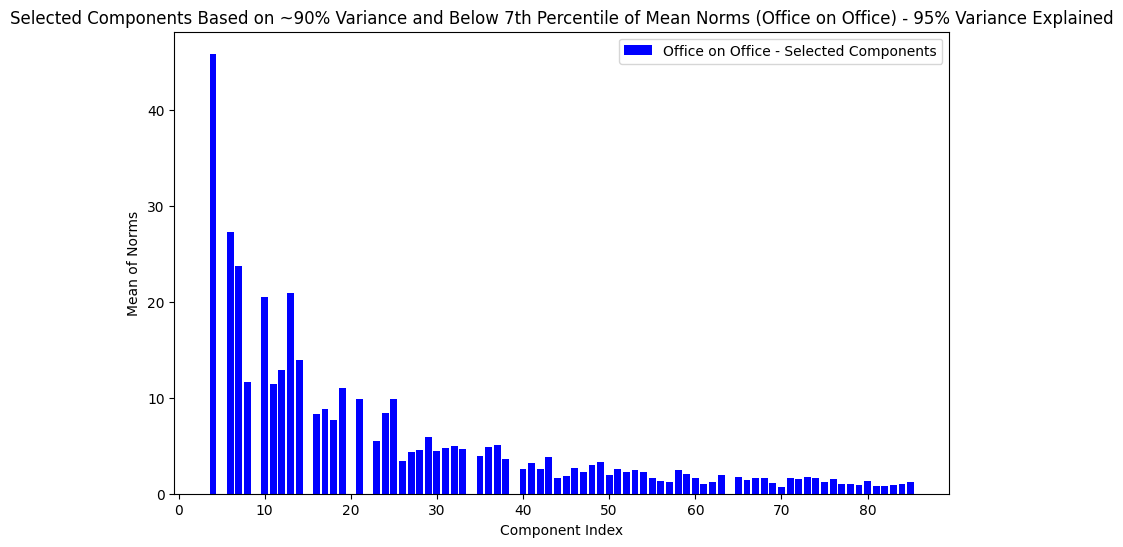

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Função para projetar patches nos componentes de uma categoria
def project_test_patches(patches, pca_components):
    projected = np.dot(patches, pca_components.T)
    
    # Verifica se o resultado é unidimensional e expande para duas dimensões, se necessário
    if len(projected.shape) == 1:
        projected = np.expand_dims(projected, axis=0)
    
    return projected

# Função para calcular normas, médias e médias das normas dos produtos internos no mesmo componente
def calculate_norms_and_means(projections_A, projections_B):
    norms = []
    means = []
    means_norms = []

    # Certifique-se de que projections_A tenha pelo menos duas dimensões
    if len(projections_A.shape) < 2:
        raise ValueError("projections_A must have at least two dimensions (patches, components).")
    
    for i in range(projections_A.shape[1]):  # Itera sobre os componentes
        dot_products = np.dot(projections_A[:, i], projections_B[:, i].T)
        norms.append(np.linalg.norm(dot_products))
        means.append(np.mean(dot_products))
        means_norms.append(np.mean(np.linalg.norm(dot_products)))
        
    return norms, means, means_norms

# Função para capturar componentes que explicam ~90% da variância e cujas normas estão abaixo do percentil desejado e de um limite superior
def capture_components_by_percentile_and_threshold(explained_variance_ratio, means_norms, variance_threshold=0.9, exclude_first=True, norm_threshold=50):
    # Calcular a variância explicada cumulativa
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Capturar os índices que explicam até ~90% da variância
    selected_indices = np.where(cumulative_variance <= variance_threshold)[0]
    
    # Excluir a primeira componente se necessário
    if exclude_first and 0 in selected_indices:
        selected_indices = selected_indices[selected_indices != 0]
    
    # Garantir que selected_indices seja uma lista de inteiros
    selected_indices = list(map(int, selected_indices))
    
    # Calcular o percentil desejado dos means_norms
    percentile = np.percentile([means_norms[i] for i in selected_indices], 7)
    
    # Selecionar os componentes com means_norms abaixo do percentil e do limite superior
    selected_indices_filtered = [i for i in selected_indices if means_norms[i] <= percentile and means_norms[i] <= norm_threshold]
    
    return selected_indices_filtered

# Lista de categorias para iterar
categories = ['Coast', 'Office']

# Trabalhando apenas com o PCA de 95% de variância explicada
perc = 95

selected_indices_dict = {}

# Iterar sobre as categorias para calcular tanto intra-categories quanto cross-categories
for category in categories:
    for other_category in categories:
        # Carregar os componentes e variância explicada da própria categoria ou da outra categoria
        components = pca_results[perc][other_category]['components']
        explained_variance_ratio = pca_results[perc][other_category]['explained_variance_ratio']
        
        if category == other_category:
            print(f"\nCategory: {category} on {category} (Intra-Category), Percentage: {perc}%")
        else:
            print(f"\nCategory: {category} on {other_category} (Cross-Category), Percentage: {perc}%")
        
        # Projeção dos patches (intra ou cross-categoria)
        all_means_norms = []
        all_selected_indices = []
        
        # Iterando pelas imagens e patches
        for image_idx in range(centralized_test_features_by_category[category].shape[0]):
            patches = centralized_test_features_by_category[category][image_idx]  # Seleciona os patches da imagem

            # Projeta os patches nos componentes
            projected_patches = project_test_patches(patches, components)
            
            # Calcular normas, médias e médias das normas para cada imagem
            norms_category, means_category, means_norms_category = calculate_norms_and_means(projected_patches, projected_patches)
            
            # Capturar os componentes cujas médias das normas estão abaixo do percentil e explicam até ~90% da variância
            selected_indices = capture_components_by_percentile_and_threshold(explained_variance_ratio, means_norms_category, exclude_first=True, norm_threshold=50)
            
            # Armazenar os resultados de médias das normas e componentes selecionados
            all_means_norms.append(means_norms_category)
            all_selected_indices.append(selected_indices)
        
        # Verifique se existem componentes selecionados
        if len(all_selected_indices) == 0 or np.concatenate(all_selected_indices).size == 0:
            print(f"Warning: No components selected for {category} on {other_category}. Skipping this combination.")
            continue

        # Agregue os componentes selecionados em todas as imagens
        aggregated_selected_indices = np.unique(np.concatenate(all_selected_indices)).astype(int)  # Conversão para inteiros
        
        # Inicializar os dicionários se as chaves não existirem
        if category not in selected_indices_dict:
            selected_indices_dict[category] = {}
        
        selected_indices_dict[category][other_category] = aggregated_selected_indices

        # Evite plotagens se não houver componentes selecionados
        if len(aggregated_selected_indices) == 0:
            print(f"Warning: No valid components selected for {category} on {other_category}. Skipping plot.")
            continue

        # Plotar os resultados para os componentes selecionados
        plt.figure(figsize=(10, 6))
        plt.bar(aggregated_selected_indices, [np.mean([means_norms[int(i)] for means_norms in all_means_norms if int(i) < len(means_norms)]) for i in aggregated_selected_indices], 
                color='green' if category != other_category else 'blue',
                label=f'{category} on {other_category} - Selected Components')
        plt.title(f'Selected Components Based on ~90% Variance and Below 7th Percentile of Mean Norms ({category} on {other_category}) - 95% Variance Explained')
        plt.xlabel('Component Index')
        plt.ylabel('Mean of Norms')
        plt.legend()
        plt.show()


In [41]:
centered_test_office_patches = centralized_test_features_by_category['Office']
centered_test_coast_patches = centralized_test_features_by_category['Coast']

In [42]:
import os
import numpy as np

def project_and_transform_back(features, pca, specific_indices):
    """
    Projeta as features nos componentes principais específicos e reconstrói a partir desses componentes.
    """
    # Projeção das features nos componentes principais
    projected = pca.transform(features)
    
    # Usar apenas os componentes específicos
    projected_specific = projected[:, specific_indices]
    
    # Reconstruir as features apenas com os componentes específicos
    specific_components = pca.components_[specific_indices]
    reconstructed_features = np.dot(projected_specific, specific_components)
    
    return reconstructed_features

def calculate_mean_ood_for_specific_components(original_features, pca, specific_indices):
    """
    Projeta as features originais em componentes PCA específicos, reconstrói e calcula a média dos OOD scores.
    """
    total_ood_scores = []
    
    # Itera sobre todas as amostras de features
    for sample_idx in range(original_features.shape[0]):
        features = original_features[sample_idx]
        
        # Projeção e reconstrução das features nos componentes específicos
        reconstructed_features = project_and_transform_back(features.reshape(1, -1), pca, specific_indices)
        
        # Calcula os resíduos (erro de reconstrução)
        residuals = features - reconstructed_features.flatten()
        
        # Calcular a norma das features originais e dos resíduos
        original_norm = np.linalg.norm(features)
        residual_norm = np.linalg.norm(residuals)
        
        # Verifique se a norma dos resíduos é maior que a norma das features originais
        if residual_norm > original_norm:
            print(f"Warning: Residual norm ({residual_norm}) greater than original norm ({original_norm}) for sample {sample_idx}")
        
        # Calcular a pontuação OOD (norma dos resíduos sobre a norma das features originais)
        if original_norm == 0:
            ood_score = 0
        else:
            ood_score = residual_norm / original_norm
        
        # Adiciona a pontuação OOD desta amostra à lista total
        total_ood_scores.append(ood_score)
    
    # Retorna a média das pontuações OOD
    return np.mean(total_ood_scores)

# Iterar sobre as categorias para calcular as médias das pontuações OOD
mean_ood_scores = {}

for category in categories:
    for other_category in categories:
        specific_indices = selected_indices_dict[category][other_category]
        
        # Recupera os objetos PCA para as categorias correspondentes
        pca_object = pca_results[perc][other_category]['pca_object']  # Usamos os componentes do other_category
        
        # Verificar se as features de teste existem para a categoria
        if category not in centralized_test_features_by_category:
            print(f"Warning: No test features found for {category}. Skipping.")
            continue
        
        # Calcular a média das pontuações OOD com base na projeção nos componentes específicos
        mean_ood = calculate_mean_ood_for_specific_components(centralized_test_features_by_category[category], pca_object, specific_indices)
        
        # Armazenar a média no dicionário
        mean_ood_scores[f"{category}_on_{other_category}"] = mean_ood

# Exibir todas as médias calculadas
for key, mean_ood in mean_ood_scores.items():
    print(f"Mean OOD Score for {key}: {mean_ood}")


Mean OOD Score for Coast_on_Coast: 1.3130048513412476
Mean OOD Score for Coast_on_Office: 1.3666877746582031
Mean OOD Score for Office_on_Coast: 1.4851768016815186
Mean OOD Score for Office_on_Office: 1.1739089488983154


## ✌️ Part II: Comparing two similar environments

In [43]:
train_categories = ['Bedroom', 'LivingRoom']

df_different = df[df['category'].isin(train_categories)]
df_different

,image_path,category
0,../data/CBIR_15-Scene/00/1.jpg,Bedroom
1,../data/CBIR_15-Scene/00/2.jpg,Bedroom
2,../data/CBIR_15-Scene/00/3.jpg,Bedroom
3,../data/CBIR_15-Scene/00/4.jpg,Bedroom
4,../data/CBIR_15-Scene/00/5.jpg,Bedroom
...,...,...
1262,../data/CBIR_15-Scene/04/1263.jpg,LivingRoom
1263,../data/CBIR_15-Scene/04/1264.jpg,LivingRoom
1264,../data/CBIR_15-Scene/04/1265.jpg,LivingRoom
1265,../data/CBIR_15-Scene/04/1266.jpg,LivingRoom


In [44]:
X = df_different['image_path']
y = df_different['category']
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=0.2, random_state=10)

image_size = (224, 224)
unique_categories = list(df_different['category'].unique())
print(f"Unique categories: {unique_categories}")


Unique categories: ['Bedroom', 'LivingRoom']


In [45]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

In [46]:
training_images_by_category = load_images_by_category('images_train', unique_categories, image_size=(224, 224))


In [47]:
def center_images(images):
    # Calcular a média ao longo do eixo dos pixels
    # Check if images have 3 or 4 dimensions
    if len(images.shape) == 3:
        num_images, height, width = images.shape
        # For grayscale images, no need for the 'channels' dimension
        mean_image = np.mean(images, axis=(1, 2), keepdims=True)
    elif len(images.shape) == 4:
        num_images, height, width, channels = images.shape
        mean_image = np.mean(images, axis=(1, 2, 3), keepdims=True)
    else:
        raise ValueError("Unexpected image shape")

    # Subtract the mean from each image
    centered_images = images - mean_image
    
    return centered_images

centered_images_by_category = {}
for category, images in training_images_by_category.items():
    print(images.shape)
    centered_images = center_images(images)
    centered_images_by_category[category] = centered_images
    print(f"Category {category}, images shape: {centered_images.shape}")


(173, 224, 224)
Category Bedroom, images shape: (173, 224, 224)
(231, 224, 224)
Category LivingRoom, images shape: (231, 224, 224)


In [48]:
import numpy as np

def convert_grayscale_to_rgb(images):
    return np.stack((images,) * 3, axis=-1)

preprocessed_images_by_category = centered_images_by_category 
features_by_category = {}
for category, images in preprocessed_images_by_category.items():
    # Verifica se a imagem está em grayscale
    if images.shape[-1] != 3:
        images = convert_grayscale_to_rgb(images)
    features = model.predict(images)
    features_by_category[category] = features


for category, features in features_by_category.items():
    print(f"Category {category}, features shape: {features.shape}")


8/8 [==============================] - 15s 2s/step
Category Bedroom, features shape: (173, 4096)
Category LivingRoom, features shape: (231, 4096)


In [49]:
pca_by_category = {}
explained_variance_by_category = {}

for category, features in features_by_category.items():
    pca = PCA(n_components=0.95)  
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, principal components: {principal_components.shape[1]}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, principal components shape: {pca.components_.shape}")
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")


Category Bedroom, principal components: 118
Category LivingRoom, principal components: 145
Category Bedroom, principal components shape: (118, 4096)
Category Bedroom, explained variance: 95.05%
Category LivingRoom, principal components shape: (145, 4096)
Category LivingRoom, explained variance: 95.10%


# Test

In [50]:
def load_and_preprocess_test_images(test_dir, categories, image_size, input_size):
    test_images_by_category = load_images_by_category(test_dir, categories, image_size)
    test_centered_images_by_category = {}
    test_scalers_by_category = {}

    for category, images in test_images_by_category.items():
        test_centered_images = center_images(images)
        test_centered_images_by_category[category] = test_centered_images

    return test_centered_images_by_category

image_size = (224, 224)

test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size=(224,224))


In [51]:
import numpy as np

def ensure_rgb_format(images):
    # Verifique se as imagens têm três dimensões (batch_size, height, width)
    if len(images.shape) == 3:  
        # Se for grayscale, expanda a dimensão para criar imagens com 3 canais (RGB)
        images = np.stack((images,) * 3, axis=-1)
    return images

def extract_features_with_vgg16(model, preprocessed_images_by_category):
    features_by_category = {}
    for category, images in preprocessed_images_by_category.items():
        # Garanta que as imagens estão no formato RGB correto
        images = ensure_rgb_format(images)
        
        # Realize a predição com o modelo
        features = model.predict(images)
        features_by_category[category] = features
    return features_by_category

# Agora extraia as características usando o modelo
test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_images_by_category)


2/2 [==============================] - 4s 2s/step


In [52]:
def centralize_features(features_by_category):
    centralized_features_by_category = {}
    for category, features in features_by_category.items():
        # Centralize as features subtraindo a média
        mean_features = np.mean(features, axis=0)
        centralized_features = features - mean_features
        centralized_features_by_category[category] = centralized_features
        
        print(f"Category {category}: centralized features shape = {centralized_features.shape}")
        print(f"Category {category}: mean of centralized features = {np.mean(centralized_features, axis=0)}")  # Deve estar próximo de 0
    return centralized_features_by_category

centralized_test_features_by_category = centralize_features(test_features_by_category)

Category Bedroom: centralized features shape = (43, 4096)
Category Bedroom: mean of centralized features = [-1.5802162e-07  2.0099240e-07  1.2648660e-08 ...  2.1485395e-08
  1.1262505e-09 -9.0100043e-09]
Category LivingRoom: centralized features shape = (58, 4096)
Category LivingRoom: mean of centralized features = [-1.3770729e-07  1.2126462e-07 -9.7628297e-09 ...  9.5059134e-09
 -1.6956493e-08  6.1659979e-09]


In [53]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in centralized_test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Bedroom
Category Bedroom, mean reconstruction error: 0.11420100182294846
Category LivingRoom, mean reconstruction error: 0.11497751623392105
Best category: Bedroom
Test category: LivingRoom
Category Bedroom, mean reconstruction error: 0.10712066292762756
Category LivingRoom, mean reconstruction error: 0.09618084132671356
Best category: LivingRoom


## Agnostic Spaces

In [54]:

from sklearn.decomposition import PCA
import numpy as np

# Inicializar o dicionário para armazenar os resultados de PCA
pca_results = {}

# Lista de percentuais de variância explicada para os quais você quer calcular
percentages = [95]
categories = ['Bedroom', 'LivingRoom']

# Loop através de diferentes percentuais de variância explicada
for perc in percentages:
    # Inicializar dicionários para armazenar os resultados
    pca_by_category = {}
    explained_variance_by_category = {}

    # Loop através de categorias
    for category, features in features_by_category.items():
        # Inicializar PCA com a porcentagem especificada
        pca = PCA(n_components=perc / 100.0)
        principal_components = pca.fit_transform(features)
        
        # Armazenar os resultados do PCA para cada categoria
        pca_by_category[category] = pca
        explained_variance_by_category[category] = pca.explained_variance_ratio_
        
        print(f"Category {category}, principal components: {principal_components.shape[1]}")

    # Armazenar resultados no dicionário principal pca_results
    pca_results[perc] = {}
    for category in categories:
        if category in pca_by_category:
            pca = pca_by_category[category]
            components = pca.components_
            explained_variance_ratio = pca.explained_variance_ratio_
            
            # Armazenar os componentes, a variância explicada e o objeto PCA
            pca_results[perc][category] = {
                'components': components,
                'explained_variance_ratio': explained_variance_ratio,
                'pca_object': pca
            }
            
            print(f"Category {category}, principal components shape: {components.shape}")
            print(f"Category {category}, explained variance: {np.sum(explained_variance_ratio) * 100:.2f}%")
        else:
            print(f"Categoria '{category}' não está presente nos dados para {perc}%.")


Category Bedroom, principal components: 118
Category LivingRoom, principal components: 145
Category Bedroom, principal components shape: (118, 4096)
Category Bedroom, explained variance: 95.05%
Category LivingRoom, principal components shape: (145, 4096)
Category LivingRoom, explained variance: 95.10%


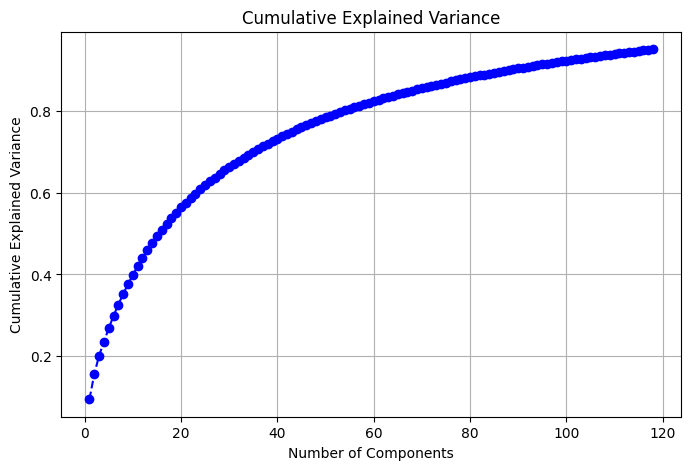

In [55]:
# Verificar se a estrutura de pca_results contém a variância explicada
percentage_to_use = 95  # Escolha a porcentagem que deseja usar
category_to_use = 'Bedroom'  # Escolha a categoria para analisar

if percentage_to_use in pca_results:
    if category_to_use in pca_results[percentage_to_use]:
        explained_variance_ratio = pca_results[percentage_to_use][category_to_use].get('explained_variance_ratio', None)
        
        if explained_variance_ratio is not None:
            plot_cumulative_variance(explained_variance_ratio)
        else:
            print(f"Explained variance ratio not found for {category_to_use} at {percentage_to_use}%.")
    else:
        print(f"Category '{category_to_use}' not found for {percentage_to_use}%.")
else:
    print(f"Percentage '{percentage_to_use}%' not found in pca_results.")


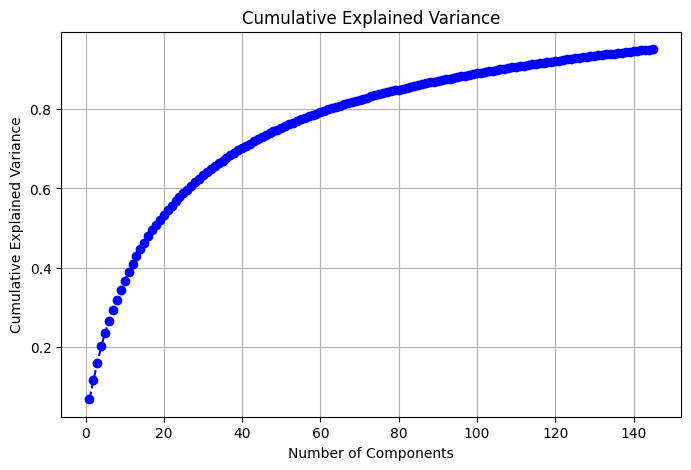

In [56]:
# Verificar se a estrutura de pca_results contém a variância explicada
percentage_to_use = 95  # Escolha a porcentagem que deseja usar
category_to_use = 'LivingRoom'  # Escolha a categoria para analisar

if percentage_to_use in pca_results:
    if category_to_use in pca_results[percentage_to_use]:
        explained_variance_ratio = pca_results[percentage_to_use][category_to_use].get('explained_variance_ratio', None)
        
        if explained_variance_ratio is not None:
            plot_cumulative_variance(explained_variance_ratio)
        else:
            print(f"Explained variance ratio not found for {category_to_use} at {percentage_to_use}%.")
    else:
        print(f"Category '{category_to_use}' not found for {percentage_to_use}%.")
else:
    print(f"Percentage '{percentage_to_use}%' not found in pca_results.")



Category: Bedroom on Bedroom (Intra-Category), Percentage: 95%


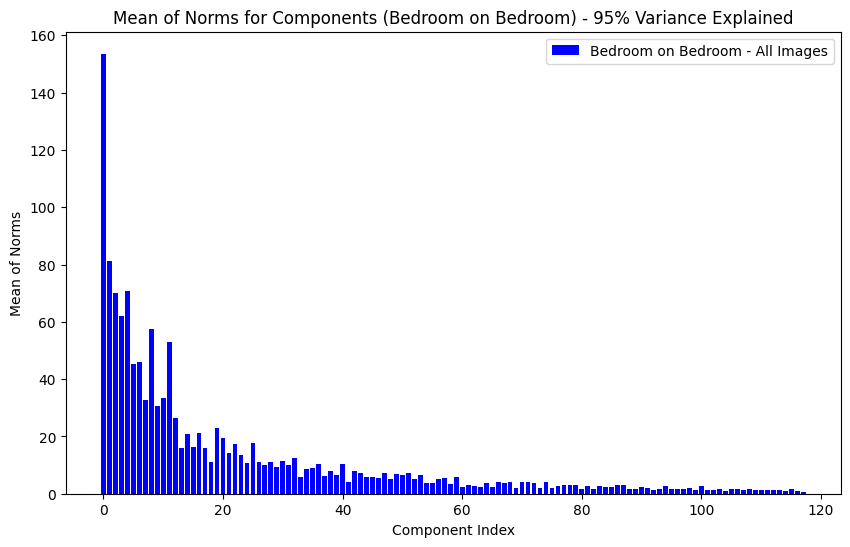


Category: Bedroom on LivingRoom (Cross-Category), Percentage: 95%


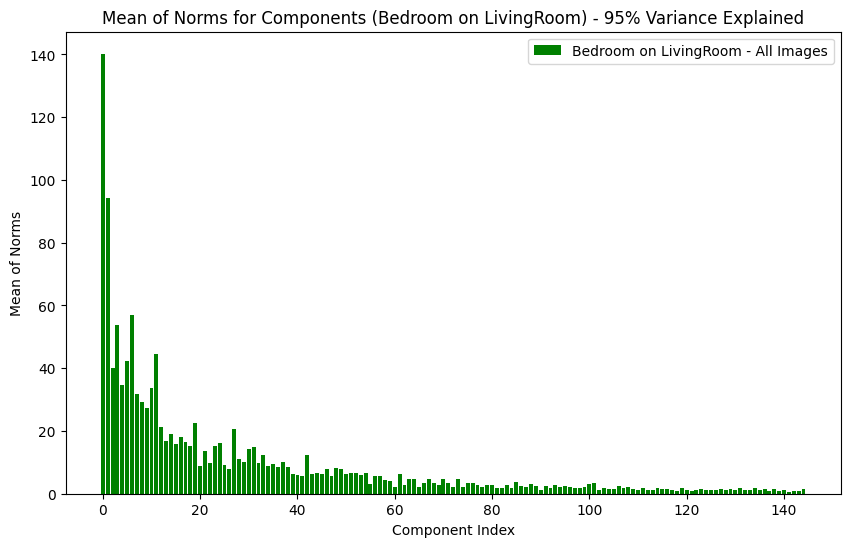


Category: LivingRoom on Bedroom (Cross-Category), Percentage: 95%


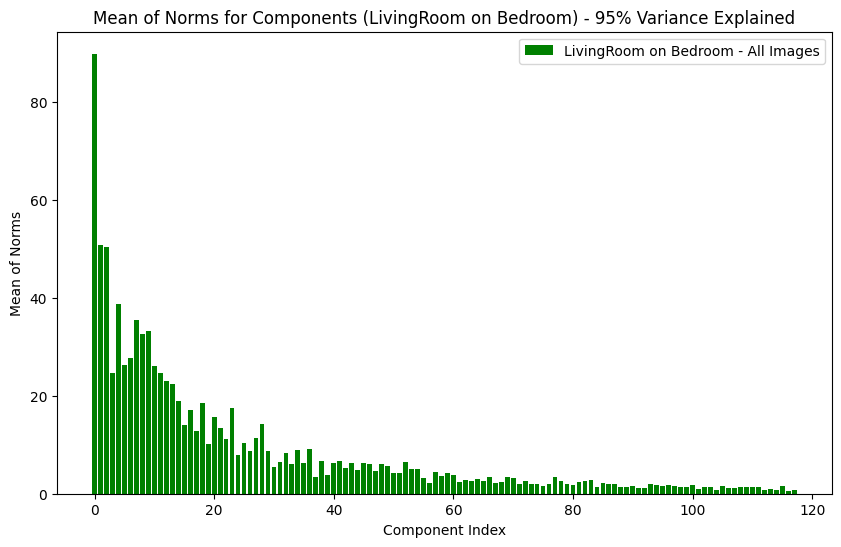


Category: LivingRoom on LivingRoom (Intra-Category), Percentage: 95%


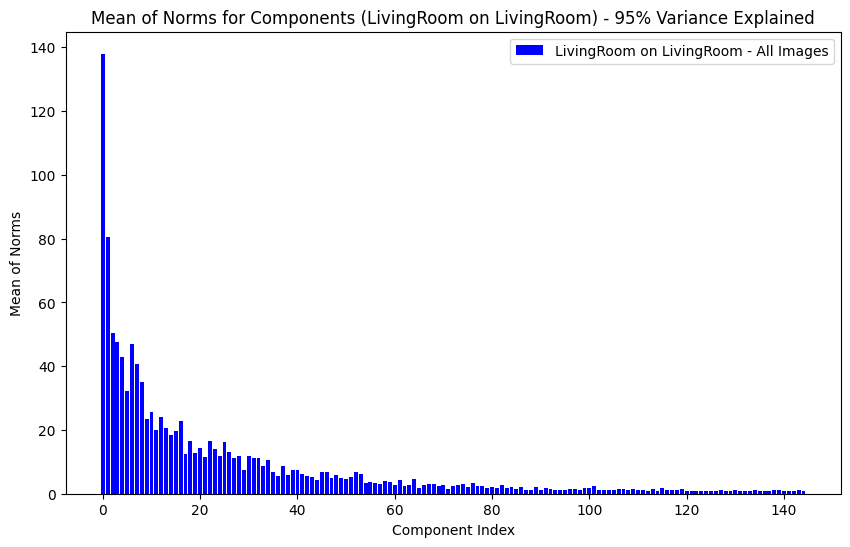

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Função para projetar patches nos componentes de uma categoria
def project_test_patches(patches, pca_components):
    # Certifique-se de que patches tem pelo menos 2 dimensões
    if len(patches.shape) == 1:
        patches = np.expand_dims(patches, axis=0)  # Expande para (1, n_features)
    
    return np.dot(patches, pca_components.T)

# Função para calcular normas, médias e médias das normas dos produtos internos no mesmo componente
def calculate_norms_and_means(projections_A, projections_B):
    norms = []
    means = []
    means_norms = []

    # Verificar se projections_A e projections_B têm pelo menos duas dimensões
    if len(projections_A.shape) < 2 or len(projections_B.shape) < 2:
        raise ValueError("Projections must have at least two dimensions (patches, components).")

    for i in range(projections_A.shape[1]):  # Itera sobre os componentes
        dot_products = np.dot(projections_A[:, i], projections_B[:, i].T)
        norms.append(np.linalg.norm(dot_products))
        means.append(np.mean(dot_products))
        means_norms.append(np.mean(np.linalg.norm(dot_products)))
        
    return norms, means, means_norms

# Função para plotar as normas médias para todas as imagens combinadas
def plot_mean_norms_for_all_images(category, other_category, mean_of_means_norms, color='blue'):
    plt.figure(figsize=(10, 6))
    
    # Plotar os resultados para todos os componentes combinados em todas as imagens
    plt.bar(range(len(mean_of_means_norms)), mean_of_means_norms, color=color,
            label=f'{category} on {other_category} - All Images')
    
    plt.title(f'Mean of Norms for Components ({category} on {other_category}) - 95% Variance Explained')
    plt.xlabel('Component Index')
    plt.ylabel('Mean of Norms')
    plt.legend()
    plt.show()

# Lista de categorias para iterar
categories = ['Bedroom', 'LivingRoom']

# Trabalhando apenas com o PCA de 95% de variância explicada
perc = 95

# Iterar sobre as categorias para calcular tanto intra-categories quanto cross-categories
for category in categories:
    for other_category in categories:
        # Carregar os componentes da própria categoria ou da outra categoria
        components = pca_results[perc][other_category]['components']
        
        if category == other_category:
            print(f"\nCategory: {category} on {category} (Intra-Category), Percentage: {perc}%")
            color = 'blue'
        else:
            print(f"\nCategory: {category} on {other_category} (Cross-Category), Percentage: {perc}%")
            color = 'green'
        
        # Armazenar as normas médias para todas as imagens
        all_means_norms = []
        
        # Projeção dos patches (intra ou cross-categoria) para todas as imagens
        # Itera sobre cada imagem no array de features
        for image_idx in range(centralized_test_features_by_category[category].shape[0]):
            patches = centralized_test_features_by_category[category][image_idx]  # Seleciona os patches da imagem

            # Projeta os patches nos componentes
            projected_patches = project_test_patches(patches, components)
            
            # Verifique a forma de projected_patches
            if len(projected_patches.shape) < 2 or projected_patches.shape[1] != components.shape[0]:
                raise ValueError(f"Projected patches have unexpected shape: {projected_patches.shape}. Expected at least 2 dimensions and components matching PCA.")
            
            # Calcular normas, médias e médias das normas para cada imagem
            _, _, means_norms_category = calculate_norms_and_means(projected_patches, projected_patches)
            
            # Armazenar as normas calculadas para a imagem
            all_means_norms.append(means_norms_category)
        
        # Calcular a média das normas para todas as imagens
        mean_of_means_norms = np.mean(all_means_norms, axis=0)  # Média das normas em todas as imagens
        
        # Plotar os valores médios das normas para todos os componentes combinados
        plot_mean_norms_for_all_images(category, other_category, mean_of_means_norms, color=color)



Category: Bedroom on Bedroom (Intra-Category), Percentage: 95%


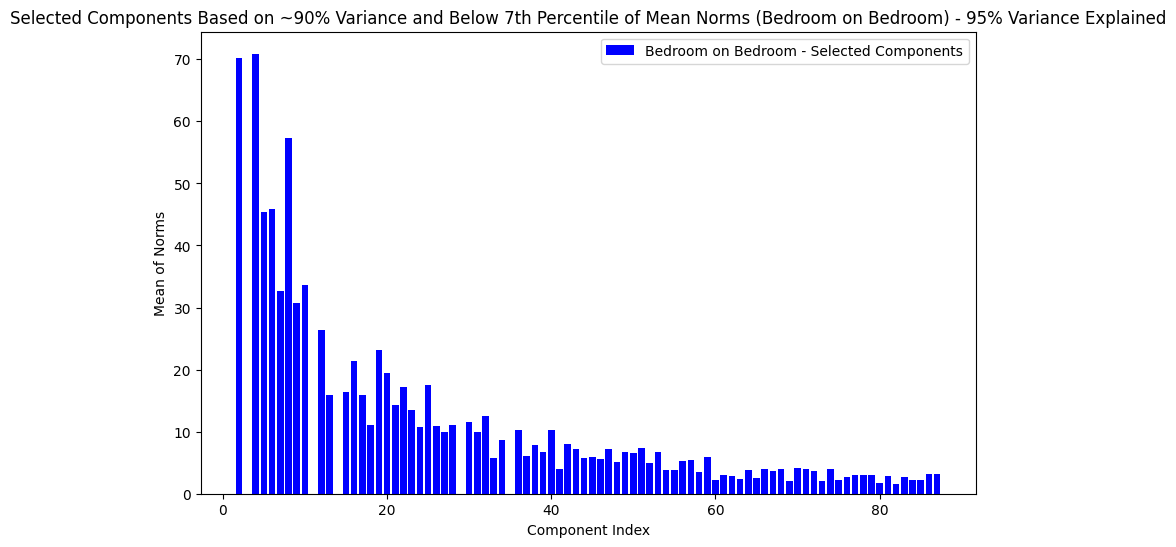


Category: Bedroom on LivingRoom (Cross-Category), Percentage: 95%


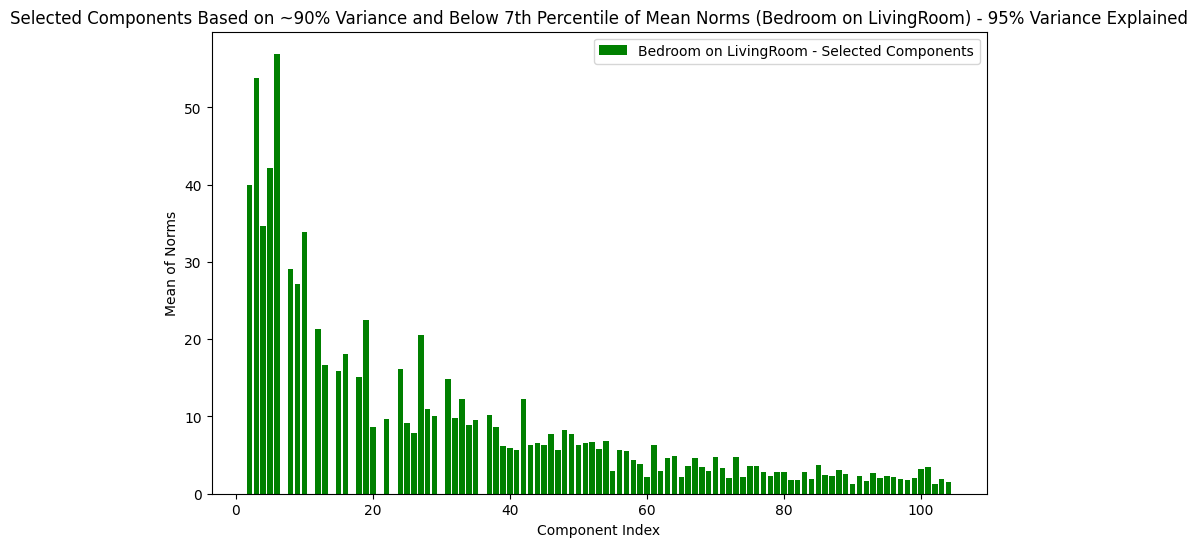


Category: LivingRoom on Bedroom (Cross-Category), Percentage: 95%


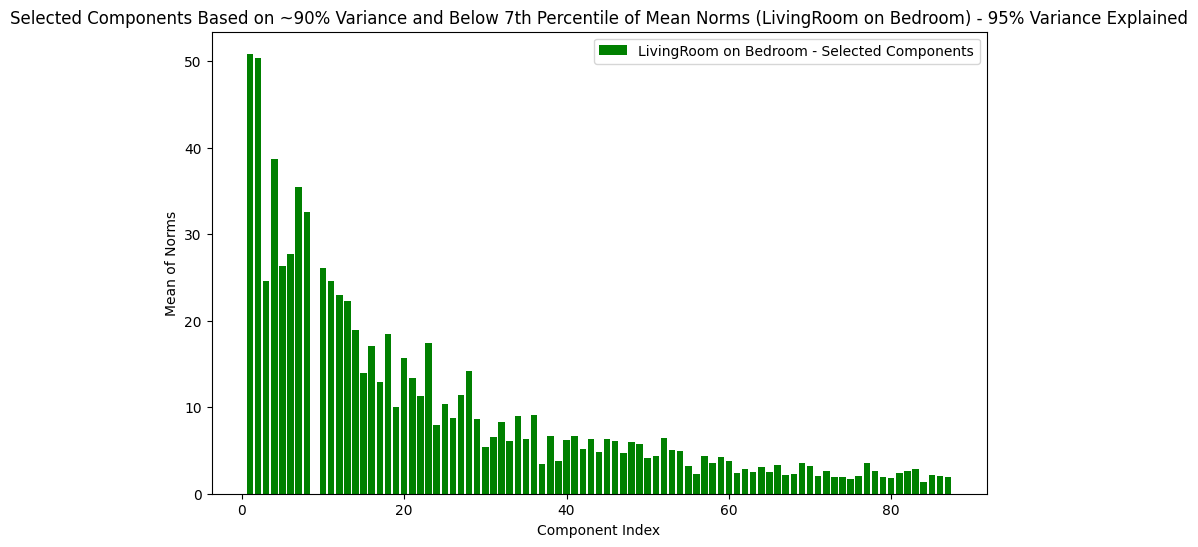


Category: LivingRoom on LivingRoom (Intra-Category), Percentage: 95%


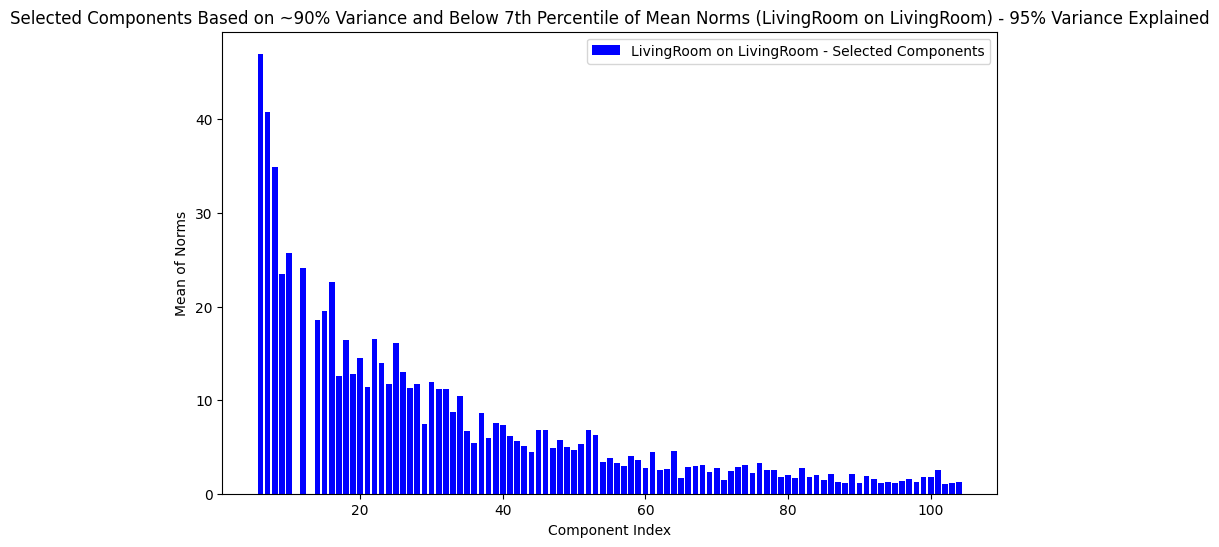

In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Função para projetar patches nos componentes de uma categoria
def project_test_patches(patches, pca_components):
    projected = np.dot(patches, pca_components.T)
    
    # Verifica se o resultado é unidimensional e expande para duas dimensões, se necessário
    if len(projected.shape) == 1:
        projected = np.expand_dims(projected, axis=0)
    
    return projected

# Função para calcular normas, médias e médias das normas dos produtos internos no mesmo componente
def calculate_norms_and_means(projections_A, projections_B):
    norms = []
    means = []
    means_norms = []

    # Certifique-se de que projections_A tenha pelo menos duas dimensões
    if len(projections_A.shape) < 2:
        raise ValueError("projections_A must have at least two dimensions (patches, components).")
    
    for i in range(projections_A.shape[1]):  # Itera sobre os componentes
        dot_products = np.dot(projections_A[:, i], projections_B[:, i].T)
        norms.append(np.linalg.norm(dot_products))
        means.append(np.mean(dot_products))
        means_norms.append(np.mean(np.linalg.norm(dot_products)))
        
    return norms, means, means_norms

# Função para capturar componentes que explicam ~90% da variância e cujas normas estão abaixo do percentil desejado e de um limite superior
def capture_components_by_percentile_and_threshold(explained_variance_ratio, means_norms, variance_threshold=0.9, exclude_first=True, norm_threshold=50):
    # Calcular a variância explicada cumulativa
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Capturar os índices que explicam até ~90% da variância
    selected_indices = np.where(cumulative_variance <= variance_threshold)[0]
    
    # Excluir a primeira componente se necessário
    if exclude_first and 0 in selected_indices:
        selected_indices = selected_indices[selected_indices != 0]
    
    # Garantir que selected_indices seja uma lista de inteiros
    selected_indices = list(map(int, selected_indices))
    
    # Calcular o percentil desejado dos means_norms
    percentile = np.percentile([means_norms[i] for i in selected_indices], 7)
    
    # Selecionar os componentes com means_norms abaixo do percentil e do limite superior
    selected_indices_filtered = [i for i in selected_indices if means_norms[i] <= percentile and means_norms[i] <= norm_threshold]
    
    return selected_indices_filtered

# Lista de categorias para iterar
categories = ['Bedroom', 'LivingRoom']

# Trabalhando apenas com o PCA de 95% de variância explicada
perc = 95

selected_indices_dict = {}

# Iterar sobre as categorias para calcular tanto intra-categories quanto cross-categories
for category in categories:
    for other_category in categories:
        # Carregar os componentes e variância explicada da própria categoria ou da outra categoria
        components = pca_results[perc][other_category]['components']
        explained_variance_ratio = pca_results[perc][other_category]['explained_variance_ratio']
        
        if category == other_category:
            print(f"\nCategory: {category} on {category} (Intra-Category), Percentage: {perc}%")
        else:
            print(f"\nCategory: {category} on {other_category} (Cross-Category), Percentage: {perc}%")
        
        # Projeção dos patches (intra ou cross-categoria)
        all_means_norms = []
        all_selected_indices = []
        
        # Iterando pelas imagens e patches
        for image_idx in range(centralized_test_features_by_category[category].shape[0]):
            patches = centralized_test_features_by_category[category][image_idx]  # Seleciona os patches da imagem

            # Projeta os patches nos componentes
            projected_patches = project_test_patches(patches, components)
            
            # Calcular normas, médias e médias das normas para cada imagem
            norms_category, means_category, means_norms_category = calculate_norms_and_means(projected_patches, projected_patches)
            
            # Capturar os componentes cujas médias das normas estão abaixo do percentil e explicam até ~90% da variância
            selected_indices = capture_components_by_percentile_and_threshold(explained_variance_ratio, means_norms_category, exclude_first=True, norm_threshold=50)
            
            # Armazenar os resultados de médias das normas e componentes selecionados
            all_means_norms.append(means_norms_category)
            all_selected_indices.append(selected_indices)
        
        # Verifique se existem componentes selecionados
        if len(all_selected_indices) == 0 or np.concatenate(all_selected_indices).size == 0:
            print(f"Warning: No components selected for {category} on {other_category}. Skipping this combination.")
            continue

        # Agregue os componentes selecionados em todas as imagens
        aggregated_selected_indices = np.unique(np.concatenate(all_selected_indices)).astype(int)  # Conversão para inteiros
        
        # Inicializar os dicionários se as chaves não existirem
        if category not in selected_indices_dict:
            selected_indices_dict[category] = {}
        
        selected_indices_dict[category][other_category] = aggregated_selected_indices

        # Evite plotagens se não houver componentes selecionados
        if len(aggregated_selected_indices) == 0:
            print(f"Warning: No valid components selected for {category} on {other_category}. Skipping plot.")
            continue

        # Plotar os resultados para os componentes selecionados
        plt.figure(figsize=(10, 6))
        plt.bar(aggregated_selected_indices, [np.mean([means_norms[int(i)] for means_norms in all_means_norms if int(i) < len(means_norms)]) for i in aggregated_selected_indices], 
                color='green' if category != other_category else 'blue',
                label=f'{category} on {other_category} - Selected Components')
        plt.title(f'Selected Components Based on ~90% Variance and Below 7th Percentile of Mean Norms ({category} on {other_category}) - 95% Variance Explained')
        plt.xlabel('Component Index')
        plt.ylabel('Mean of Norms')
        plt.legend()
        plt.show()


In [59]:
import os
import numpy as np

def project_and_transform_back(features, pca, specific_indices):
    """
    Projeta as features nos componentes principais específicos e reconstrói a partir desses componentes.
    """
    # Projeção das features nos componentes principais
    projected = pca.transform(features)
    
    # Usar apenas os componentes específicos
    projected_specific = projected[:, specific_indices]
    
    # Reconstruir as features apenas com os componentes específicos
    specific_components = pca.components_[specific_indices]
    reconstructed_features = np.dot(projected_specific, specific_components)
    
    return reconstructed_features

def calculate_mean_ood_for_specific_components(original_features, pca, specific_indices):
    """
    Projeta as features originais em componentes PCA específicos, reconstrói e calcula a média dos OOD scores.
    """
    total_ood_scores = []
    
    # Itera sobre todas as amostras de features
    for sample_idx in range(original_features.shape[0]):
        features = original_features[sample_idx]
        
        # Projeção e reconstrução das features nos componentes específicos
        reconstructed_features = project_and_transform_back(features.reshape(1, -1), pca, specific_indices)
        
        # Calcula os resíduos (erro de reconstrução)
        residuals = features - reconstructed_features.flatten()
        
        # Calcular a norma das features originais e dos resíduos
        original_norm = np.linalg.norm(features)
        residual_norm = np.linalg.norm(residuals)
        
        # Verifique se a norma dos resíduos é maior que a norma das features originais
        if residual_norm > original_norm:
            print(f"Warning: Residual norm ({residual_norm}) greater than original norm ({original_norm}) for sample {sample_idx}")
        
        # Calcular a pontuação OOD (norma dos resíduos sobre a norma das features originais)
        if original_norm == 0:
            ood_score = 0
        else:
            ood_score = residual_norm / original_norm
        
        # Adiciona a pontuação OOD desta amostra à lista total
        total_ood_scores.append(ood_score)
    
    # Retorna a média das pontuações OOD
    return np.mean(total_ood_scores)

# Iterar sobre as categorias para calcular as médias das pontuações OOD
mean_ood_scores = {}

for category in categories:
    for other_category in categories:
        specific_indices = selected_indices_dict[category][other_category]
        
        # Recupera os objetos PCA para as categorias correspondentes
        pca_object = pca_results[perc][other_category]['pca_object']  # Usamos os componentes do other_category
        
        # Verificar se as features de teste existem para a categoria
        if category not in centralized_test_features_by_category:
            print(f"Warning: No test features found for {category}. Skipping.")
            continue
        
        # Calcular a média das pontuações OOD com base na projeção nos componentes específicos
        mean_ood = calculate_mean_ood_for_specific_components(centralized_test_features_by_category[category], pca_object, specific_indices)
        
        # Armazenar a média no dicionário
        mean_ood_scores[f"{category}_on_{other_category}"] = mean_ood

# Exibir todas as médias calculadas
for key, mean_ood in mean_ood_scores.items():
    print(f"Mean OOD Score for {key}: {mean_ood}")


Mean OOD Score for Bedroom_on_Bedroom: 1.0220966339111328
Mean OOD Score for Bedroom_on_LivingRoom: 1.0092896223068237
Mean OOD Score for LivingRoom_on_Bedroom: 1.0694271326065063
Mean OOD Score for LivingRoom_on_LivingRoom: 1.0636695623397827


## All environments

In [60]:
X = df['image_path'].tolist()
y = df['category'].tolist()
unique_categories = list(df['category'].unique())
print(f"Unique categories: {unique_categories}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

standard_size = (224, 224)

Unique categories: ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 'Office', 'Store']


In [61]:
create_images_set(X_train, X_test, y_train, y_test, output_dir_train='images_train', output_dir_test='images_test', standard_size=standard_size)

In [62]:
training_images_by_category = load_images_by_category('images_train', unique_categories, image_size=(224, 224))


In [63]:
def center_images(images):
    # Calcular a média ao longo do eixo dos pixels
    # Check if images have 3 or 4 dimensions
    if len(images.shape) == 3:
        num_images, height, width = images.shape
        # For grayscale images, no need for the 'channels' dimension
        mean_image = np.mean(images, axis=(1, 2), keepdims=True)
    elif len(images.shape) == 4:
        num_images, height, width, channels = images.shape
        mean_image = np.mean(images, axis=(1, 2, 3), keepdims=True)
    else:
        raise ValueError("Unexpected image shape")

    # Subtract the mean from each image
    centered_images = images - mean_image
    
    return centered_images

centered_images_by_category = {}
for category, images in training_images_by_category.items():
    print(images.shape)
    centered_images = center_images(images)
    centered_images_by_category[category] = centered_images
    print(f"Category {category}, images shape: {centered_images.shape}")


(207, 224, 224)
Category Bedroom, images shape: (207, 224, 224)
(190, 224, 224)
Category Suburb, images shape: (190, 224, 224)
(251, 224, 224)
Category Industry, images shape: (251, 224, 224)
(172, 224, 224)
Category Kitchen, images shape: (172, 224, 224)
(278, 224, 224)
Category LivingRoom, images shape: (278, 224, 224)
(348, 224, 224)
Category Coast, images shape: (348, 224, 224)
(251, 224, 224)
Category Forest, images shape: (251, 224, 224)
(200, 224, 224)
Category Highway, images shape: (200, 224, 224)
(257, 224, 224)
Category InsideCity, images shape: (257, 224, 224)
(295, 224, 224)
Category Mountain, images shape: (295, 224, 224)
(340, 224, 224)
Category OpenCountry, images shape: (340, 224, 224)
(231, 224, 224)
Category Street, images shape: (231, 224, 224)
(289, 224, 224)
Category Building, images shape: (289, 224, 224)
(209, 224, 224)
Category Office, images shape: (209, 224, 224)
(245, 224, 224)
Category Store, images shape: (245, 224, 224)


In [64]:
import numpy as np

def convert_grayscale_to_rgb(images):
    return np.stack((images,) * 3, axis=-1)

preprocessed_images_by_category = centered_images_by_category 
features_by_category = {}
for category, images in preprocessed_images_by_category.items():
    # Verifica se a imagem está em grayscale
    if images.shape[-1] != 3:
        images = convert_grayscale_to_rgb(images)
    features = model.predict(images)
    features_by_category[category] = features


for category, features in features_by_category.items():
    print(f"Category {category}, features shape: {features.shape}")


8/8 [==============================] - 16s 2s/step
Category Bedroom, features shape: (207, 4096)
Category Suburb, features shape: (190, 4096)
Category Industry, features shape: (251, 4096)
Category Kitchen, features shape: (172, 4096)
Category LivingRoom, features shape: (278, 4096)
Category Coast, features shape: (348, 4096)
Category Forest, features shape: (251, 4096)
Category Highway, features shape: (200, 4096)
Category InsideCity, features shape: (257, 4096)
Category Mountain, features shape: (295, 4096)
Category OpenCountry, features shape: (340, 4096)
Category Street, features shape: (231, 4096)
Category Building, features shape: (289, 4096)
Category Office, features shape: (209, 4096)
Category Store, features shape: (245, 4096)


In [65]:
pca_by_category = {}
explained_variance_by_category = {}

for category, features in features_by_category.items():
    pca = PCA(n_components=0.95)  
    principal_components = pca.fit_transform(features)
    pca_by_category[category] = pca
    explained_variance_by_category[category] = pca.explained_variance_ratio_
    
    print(f"Category {category}, principal components: {principal_components.shape[1]}")

for category, pca in pca_by_category.items():
    print(f"Category {category}, principal components shape: {pca.components_.shape}")
    print(f"Category {category}, explained variance: {np.sum(explained_variance_by_category[category]) * 100:.2f}%")


Category Bedroom, principal components: 137
Category Suburb, principal components: 121
Category Industry, principal components: 167
Category Kitchen, principal components: 116
Category LivingRoom, principal components: 169
Category Coast, principal components: 169
Category Forest, principal components: 142
Category Highway, principal components: 109
Category InsideCity, principal components: 160
Category Mountain, principal components: 172
Category OpenCountry, principal components: 179
Category Street, principal components: 139
Category Building, principal components: 168
Category Office, principal components: 139
Category Store, principal components: 162
Category Bedroom, principal components shape: (137, 4096)
Category Bedroom, explained variance: 95.00%
Category Suburb, principal components shape: (121, 4096)
Category Suburb, explained variance: 95.02%
Category Industry, principal components shape: (167, 4096)
Category Industry, explained variance: 95.03%
Category Kitchen, principa

# Teste

In [66]:
def load_and_preprocess_test_images(test_dir, categories, image_size, input_size):
    test_images_by_category = load_images_by_category(test_dir, categories, image_size)
    test_centered_images_by_category = {}
    test_scalers_by_category = {}

    for category, images in test_images_by_category.items():
        test_centered_images = center_images(images)
        test_centered_images_by_category[category] = test_centered_images

    return test_centered_images_by_category

image_size = (224, 224)

test_preprocessed_images_by_category = load_and_preprocess_test_images('images_test', y, image_size, input_size=(224,224))


In [67]:
import numpy as np

def ensure_rgb_format(images):
    # Verifique se as imagens têm três dimensões (batch_size, height, width)
    if len(images.shape) == 3:  
        # Se for grayscale, expanda a dimensão para criar imagens com 3 canais (RGB)
        images = np.stack((images,) * 3, axis=-1)
    return images

def extract_features_with_vgg16(model, preprocessed_images_by_category):
    features_by_category = {}
    for category, images in preprocessed_images_by_category.items():
        # Garanta que as imagens estão no formato RGB correto
        images = ensure_rgb_format(images)
        
        # Realize a predição com o modelo
        features = model.predict(images)
        features_by_category[category] = features
    return features_by_category

# Agora extraia as características usando o modelo
test_features_by_category = extract_features_with_vgg16(model, test_preprocessed_images_by_category)


3/3 [==============================] - 5s 1s/step


In [68]:
def centralize_features(features_by_category):
    centralized_features_by_category = {}
    for category, features in features_by_category.items():
        # Centralize as features subtraindo a média
        mean_features = np.mean(features, axis=0)
        centralized_features = features - mean_features
        centralized_features_by_category[category] = centralized_features
        
        print(f"Category {category}: centralized features shape = {centralized_features.shape}")
        print(f"Category {category}: mean of centralized features = {np.mean(centralized_features, axis=0)}")  # Deve estar próximo de 0
    return centralized_features_by_category

centralized_test_features_by_category = centralize_features(test_features_by_category)

Category Bedroom: centralized features shape = (78, 4096)
Category Bedroom: mean of centralized features = [-6.4189621e-08  2.2924864e-08 -1.5283242e-09 ... -1.2417634e-08
 -1.0125148e-08 -1.4519080e-08]
Category Suburb: centralized features shape = (51, 4096)
Category Suburb: mean of centralized features = [ 4.4995662e-08 -2.3374371e-08 -7.0123112e-09 ...  7.4797988e-08
  1.6362060e-08 -1.6362060e-08]
Category Industry: centralized features shape = (60, 4096)
Category Industry: mean of centralized features = [-2.4338563e-08 -6.7551930e-08 -5.9604645e-08 ... -1.0132790e-07
  8.2453091e-08  2.2600094e-08]
Category Kitchen: centralized features shape = (38, 4096)
Category Kitchen: mean of centralized features = [ 1.6783413e-07  3.1684576e-07 -1.2548346e-08 ...  0.0000000e+00
  1.5685433e-09 -1.8822519e-08]
Category LivingRoom: centralized features shape = (101, 4096)
Category LivingRoom: mean of centralized features = [-1.06816245e-07 -6.84568207e-08  0.00000000e+00 ...  6.34405861e-09
 

In [69]:
def calculate_reconstruction_error(test_features, pca_by_category):
    reconstruction_errors_by_category = {}
    mean_reconstruction_errors_by_category = {}
    
    for category, pca in pca_by_category.items():
        principal_components = pca.transform(test_features)
        reconstructed_features = pca.inverse_transform(principal_components)
        
        reconstruction_error = np.linalg.norm(test_features - reconstructed_features, axis=1)
        reconstruction_errors_by_category[category] = reconstruction_error / np.linalg.norm(test_features)

    for category, errors in reconstruction_errors_by_category.items():
        mean_reconstruction_errors_by_category[category] = np.mean(errors)
    
    best_category = min(mean_reconstruction_errors_by_category, key=mean_reconstruction_errors_by_category.get)

    for category in mean_reconstruction_errors_by_category:
        print(f"Category {category}, mean reconstruction error: {mean_reconstruction_errors_by_category[category]}")
    
    print(f"Best category: {best_category}")
    print("=====================================")

    return mean_reconstruction_errors_by_category, best_category

for category, test_features in centralized_test_features_by_category.items():
    print(f"Test category: {category}")
    mean_reconstruction_errors, best_category = calculate_reconstruction_error(test_features, pca_by_category)


Test category: Bedroom
Category Bedroom, mean reconstruction error: 0.05854791775345802
Category Suburb, mean reconstruction error: 0.10865739732980728
Category Industry, mean reconstruction error: 0.10485368221998215
Category Kitchen, mean reconstruction error: 0.09567480534315109
Category LivingRoom, mean reconstruction error: 0.0811157375574112
Category Coast, mean reconstruction error: 0.10155247151851654
Category Forest, mean reconstruction error: 0.10608799010515213
Category Highway, mean reconstruction error: 0.11265331506729126
Category InsideCity, mean reconstruction error: 0.10136353969573975
Category Mountain, mean reconstruction error: 0.1043703630566597
Category OpenCountry, mean reconstruction error: 0.1017584353685379
Category Street, mean reconstruction error: 0.10507669299840927
Category Building, mean reconstruction error: 0.10111669450998306
Category Office, mean reconstruction error: 0.09230711311101913
Category Store, mean reconstruction error: 0.10302911698818207


Category Bedroom, mean reconstruction error: 0.05854791775345802
Category Suburb, mean reconstruction error: 0.10865739732980728
Category Industry, mean reconstruction error: 0.10485368221998215
Category Kitchen, mean reconstruction error: 0.09567480534315109
Category LivingRoom, mean reconstruction error: 0.0811157375574112
Category Coast, mean reconstruction error: 0.10155247151851654
Category Forest, mean reconstruction error: 0.10608799010515213
Category Highway, mean reconstruction error: 0.11265331506729126
Category InsideCity, mean reconstruction error: 0.10136353969573975
Category Mountain, mean reconstruction error: 0.1043703630566597
Category OpenCountry, mean reconstruction error: 0.1017584353685379
Category Street, mean reconstruction error: 0.10507669299840927
Category Building, mean reconstruction error: 0.10111669450998306
Category Office, mean reconstruction error: 0.09230711311101913
Category Store, mean reconstruction error: 0.10302911698818207
Best category: Bedroom


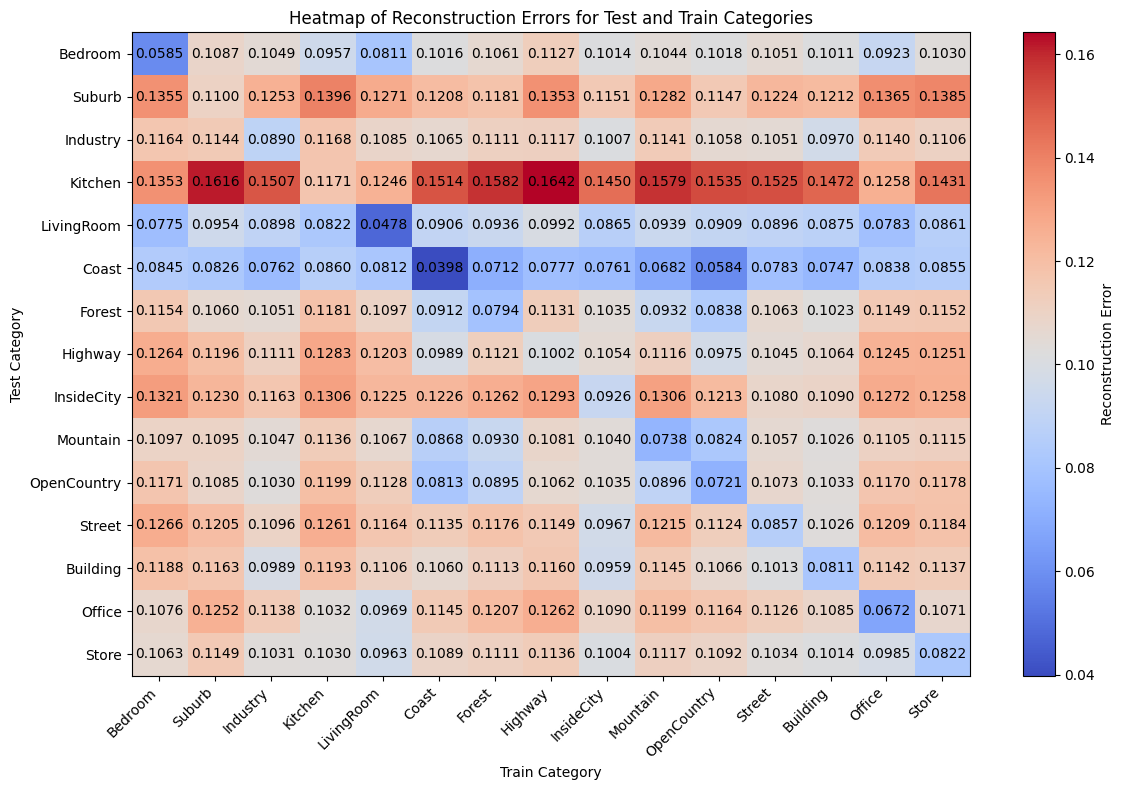

In [73]:
# Inicialize a matriz de erro de reconstrução
categories = ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 
              'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 
              'Office', 'Store']
reconstruction_error_matrix = np.zeros((len(categories), len(categories)))

# Preencher a matriz com os erros de reconstrução
for i, test_category in enumerate(categories):
    test_features = centralized_test_features_by_category[test_category]
    mean_reconstruction_errors, _ = calculate_reconstruction_error(test_features, pca_by_category)
    
    # Preencher a matriz para cada categoria de treino
    for j, train_category in enumerate(categories):
        reconstruction_error_matrix[i, j] = mean_reconstruction_errors.get(train_category, np.nan)

# Criar DataFrame para facilitar o plot
reconstruction_error_df = pd.DataFrame(reconstruction_error_matrix, index=categories, columns=categories)

# Plotar o heatmap usando matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Criar o heatmap usando imshow
cax = ax.imshow(reconstruction_error_df, cmap="coolwarm", aspect="auto")

# Adicionar valores na matriz
for i in range(len(categories)):
    for j in range(len(categories)):
        value = reconstruction_error_matrix[i, j]
        ax.text(j, i, f'{value:.4f}', ha='center', va='center', color='black')

# Configurar os eixos
ax.set_xticks(np.arange(len(categories)))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.set_yticklabels(categories)

# Adicionar título e rótulos dos eixos
ax.set_title('Heatmap of Reconstruction Errors for Test and Train Categories')
ax.set_xlabel('Train Category')
ax.set_ylabel('Test Category')

# Adicionar a barra de cores
fig.colorbar(cax, ax=ax, label='Reconstruction Error')

# Ajustar layout
plt.tight_layout()

# Mostrar o heatmap
plt.show()


# Agnostic

In [74]:

from sklearn.decomposition import PCA
import numpy as np

# Inicializar o dicionário para armazenar os resultados de PCA
pca_results = {}

# Lista de percentuais de variância explicada para os quais você quer calcular
percentages = [95]
categories = ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 
              'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 
              'Office', 'Store']

# Loop através de diferentes percentuais de variância explicada
for perc in percentages:
    # Inicializar dicionários para armazenar os resultados
    pca_by_category = {}
    explained_variance_by_category = {}

    # Loop através de categorias
    for category, features in features_by_category.items():
        # Inicializar PCA com a porcentagem especificada
        pca = PCA(n_components=perc / 100.0)
        principal_components = pca.fit_transform(features)
        
        # Armazenar os resultados do PCA para cada categoria
        pca_by_category[category] = pca
        explained_variance_by_category[category] = pca.explained_variance_ratio_
        
        print(f"Category {category}, principal components: {principal_components.shape[1]}")

    # Armazenar resultados no dicionário principal pca_results
    pca_results[perc] = {}
    for category in categories:
        if category in pca_by_category:
            pca = pca_by_category[category]
            components = pca.components_
            explained_variance_ratio = pca.explained_variance_ratio_
            
            # Armazenar os componentes, a variância explicada e o objeto PCA
            pca_results[perc][category] = {
                'components': components,
                'explained_variance_ratio': explained_variance_ratio,
                'pca_object': pca
            }
            
            print(f"Category {category}, principal components shape: {components.shape}")
            print(f"Category {category}, explained variance: {np.sum(explained_variance_ratio) * 100:.2f}%")
        else:
            print(f"Categoria '{category}' não está presente nos dados para {perc}%.")


Category Bedroom, principal components: 137
Category Suburb, principal components: 121
Category Industry, principal components: 167
Category Kitchen, principal components: 116
Category LivingRoom, principal components: 169
Category Coast, principal components: 169
Category Forest, principal components: 142
Category Highway, principal components: 109
Category InsideCity, principal components: 160
Category Mountain, principal components: 172
Category OpenCountry, principal components: 179
Category Street, principal components: 139
Category Building, principal components: 168
Category Office, principal components: 139
Category Store, principal components: 162
Category Bedroom, principal components shape: (137, 4096)
Category Bedroom, explained variance: 95.00%
Category Suburb, principal components shape: (121, 4096)
Category Suburb, explained variance: 95.02%
Category Industry, principal components shape: (167, 4096)
Category Industry, explained variance: 95.03%
Category Kitchen, principa

In [75]:
import numpy as np
import matplotlib.pyplot as plt

# Função para projetar patches nos componentes de uma categoria
def project_test_patches(patches, pca_components):
    # Certifique-se de que patches tem pelo menos 2 dimensões
    if len(patches.shape) == 1:
        patches = np.expand_dims(patches, axis=0)  # Expande para (1, n_features)
    
    return np.dot(patches, pca_components.T)

# Função para calcular normas, médias e médias das normas dos produtos internos no mesmo componente
def calculate_norms_and_means(projections_A, projections_B):
    norms = []
    means = []
    means_norms = []

    # Verificar se projections_A e projections_B têm pelo menos duas dimensões
    if len(projections_A.shape) < 2 or len(projections_B.shape) < 2:
        raise ValueError("Projections must have at least two dimensions (patches, components).")

    for i in range(projections_A.shape[1]):  # Itera sobre os componentes
        dot_products = np.dot(projections_A[:, i], projections_B[:, i].T)
        norms.append(np.linalg.norm(dot_products))
        means.append(np.mean(dot_products))
        means_norms.append(np.mean(np.linalg.norm(dot_products)))
        
    return norms, means, means_norms

# Função para plotar as normas médias para todas as imagens combinadas
def plot_mean_norms_for_all_images(category, other_category, mean_of_means_norms, color='blue'):
    plt.figure(figsize=(10, 6))
    
    # Plotar os resultados para todos os componentes combinados em todas as imagens
    plt.bar(range(len(mean_of_means_norms)), mean_of_means_norms, color=color,
            label=f'{category} on {other_category} - All Images')
    
    plt.title(f'Mean of Norms for Components ({category} on {other_category}) - 95% Variance Explained')
    plt.xlabel('Component Index')
    plt.ylabel('Mean of Norms')
    plt.legend()
    plt.show()

# Lista de categorias para iterar
categories = ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 
              'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 
              'Office', 'Store']

# Trabalhando apenas com o PCA de 95% de variância explicada
perc = 95

# Iterar sobre as categorias para calcular tanto intra-categories quanto cross-categories
for category in categories:
    for other_category in categories:
        # Carregar os componentes da própria categoria ou da outra categoria
        components = pca_results[perc][other_category]['components']
        
        if category == other_category:
            print(f"\nCategory: {category} on {category} (Intra-Category), Percentage: {perc}%")
            color = 'blue'
        else:
            print(f"\nCategory: {category} on {other_category} (Cross-Category), Percentage: {perc}%")
            color = 'green'
        
        # Armazenar as normas médias para todas as imagens
        all_means_norms = []
        
        # Projeção dos patches (intra ou cross-categoria) para todas as imagens
        # Itera sobre cada imagem no array de features
        for image_idx in range(centralized_test_features_by_category[category].shape[0]):
            patches = centralized_test_features_by_category[category][image_idx]  # Seleciona os patches da imagem

            # Projeta os patches nos componentes
            projected_patches = project_test_patches(patches, components)
            
            # Verifique a forma de projected_patches
            if len(projected_patches.shape) < 2 or projected_patches.shape[1] != components.shape[0]:
                raise ValueError(f"Projected patches have unexpected shape: {projected_patches.shape}. Expected at least 2 dimensions and components matching PCA.")
            
            # Calcular normas, médias e médias das normas para cada imagem
            _, _, means_norms_category = calculate_norms_and_means(projected_patches, projected_patches)
            
            # Armazenar as normas calculadas para a imagem
            all_means_norms.append(means_norms_category)
        
        # Calcular a média das normas para todas as imagens
        mean_of_means_norms = np.mean(all_means_norms, axis=0)  # Média das normas em todas as imagens
        



Category: Bedroom on Bedroom (Intra-Category), Percentage: 95%

Category: Bedroom on Suburb (Cross-Category), Percentage: 95%

Category: Bedroom on Industry (Cross-Category), Percentage: 95%

Category: Bedroom on Kitchen (Cross-Category), Percentage: 95%

Category: Bedroom on LivingRoom (Cross-Category), Percentage: 95%

Category: Bedroom on Coast (Cross-Category), Percentage: 95%

Category: Bedroom on Forest (Cross-Category), Percentage: 95%

Category: Bedroom on Highway (Cross-Category), Percentage: 95%

Category: Bedroom on InsideCity (Cross-Category), Percentage: 95%

Category: Bedroom on Mountain (Cross-Category), Percentage: 95%

Category: Bedroom on OpenCountry (Cross-Category), Percentage: 95%

Category: Bedroom on Street (Cross-Category), Percentage: 95%

Category: Bedroom on Building (Cross-Category), Percentage: 95%

Category: Bedroom on Office (Cross-Category), Percentage: 95%

Category: Bedroom on Store (Cross-Category), Percentage: 95%

Category: Suburb on Bedroom (Cross

In [76]:
import numpy as np
import matplotlib.pyplot as plt

# Função para projetar patches nos componentes de uma categoria
def project_test_patches(patches, pca_components):
    projected = np.dot(patches, pca_components.T)
    
    # Verifica se o resultado é unidimensional e expande para duas dimensões, se necessário
    if len(projected.shape) == 1:
        projected = np.expand_dims(projected, axis=0)
    
    return projected

# Função para calcular normas, médias e médias das normas dos produtos internos no mesmo componente
def calculate_norms_and_means(projections_A, projections_B):
    norms = []
    means = []
    means_norms = []

    # Certifique-se de que projections_A tenha pelo menos duas dimensões
    if len(projections_A.shape) < 2:
        raise ValueError("projections_A must have at least two dimensions (patches, components).")
    
    for i in range(projections_A.shape[1]):  # Itera sobre os componentes
        dot_products = np.dot(projections_A[:, i], projections_B[:, i].T)
        norms.append(np.linalg.norm(dot_products))
        means.append(np.mean(dot_products))
        means_norms.append(np.mean(np.linalg.norm(dot_products)))
        
    return norms, means, means_norms

# Função para capturar componentes que explicam ~90% da variância e cujas normas estão abaixo do percentil desejado e de um limite superior
def capture_components_by_percentile_and_threshold(explained_variance_ratio, means_norms, variance_threshold=0.9, exclude_first=True, norm_threshold=50):
    # Calcular a variância explicada cumulativa
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Capturar os índices que explicam até ~90% da variância
    selected_indices = np.where(cumulative_variance <= variance_threshold)[0]
    
    # Excluir a primeira componente se necessário
    if exclude_first and 0 in selected_indices:
        selected_indices = selected_indices[selected_indices != 0]
    
    # Garantir que selected_indices seja uma lista de inteiros
    selected_indices = list(map(int, selected_indices))
    
    # Calcular o percentil desejado dos means_norms
    percentile = np.percentile([means_norms[i] for i in selected_indices], 7)
    
    # Selecionar os componentes com means_norms abaixo do percentil e do limite superior
    selected_indices_filtered = [i for i in selected_indices if means_norms[i] <= percentile and means_norms[i] <= norm_threshold]
    
    return selected_indices_filtered

# Lista de categorias para iterar
categories = ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 
              'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 
              'Office', 'Store']

# Trabalhando apenas com o PCA de 95% de variância explicada
perc = 95

selected_indices_dict = {}

# Iterar sobre as categorias para calcular tanto intra-categories quanto cross-categories
for category in categories:
    for other_category in categories:
        # Carregar os componentes e variância explicada da própria categoria ou da outra categoria
        components = pca_results[perc][other_category]['components']
        explained_variance_ratio = pca_results[perc][other_category]['explained_variance_ratio']
        
        if category == other_category:
            print(f"\nCategory: {category} on {category} (Intra-Category), Percentage: {perc}%")
        else:
            print(f"\nCategory: {category} on {other_category} (Cross-Category), Percentage: {perc}%")
        
        # Projeção dos patches (intra ou cross-categoria)
        all_means_norms = []
        all_selected_indices = []
        
        # Iterando pelas imagens e patches
        for image_idx in range(centralized_test_features_by_category[category].shape[0]):
            patches = centralized_test_features_by_category[category][image_idx]  # Seleciona os patches da imagem

            # Projeta os patches nos componentes
            projected_patches = project_test_patches(patches, components)
            
            # Calcular normas, médias e médias das normas para cada imagem
            norms_category, means_category, means_norms_category = calculate_norms_and_means(projected_patches, projected_patches)
            
            # Capturar os componentes cujas médias das normas estão abaixo do percentil e explicam até ~90% da variância
            selected_indices = capture_components_by_percentile_and_threshold(explained_variance_ratio, means_norms_category, exclude_first=True, norm_threshold=50)
            
            # Armazenar os resultados de médias das normas e componentes selecionados
            all_means_norms.append(means_norms_category)
            all_selected_indices.append(selected_indices)
        
        # Verifique se existem componentes selecionados
        if len(all_selected_indices) == 0 or np.concatenate(all_selected_indices).size == 0:
            print(f"Warning: No components selected for {category} on {other_category}. Skipping this combination.")
            continue

        # Agregue os componentes selecionados em todas as imagens
        aggregated_selected_indices = np.unique(np.concatenate(all_selected_indices)).astype(int)  # Conversão para inteiros
        
        # Inicializar os dicionários se as chaves não existirem
        if category not in selected_indices_dict:
            selected_indices_dict[category] = {}
        
        selected_indices_dict[category][other_category] = aggregated_selected_indices

        # Evite plotagens se não houver componentes selecionados
        if len(aggregated_selected_indices) == 0:
            print(f"Warning: No valid components selected for {category} on {other_category}. Skipping plot.")
            continue



Category: Bedroom on Bedroom (Intra-Category), Percentage: 95%

Category: Bedroom on Suburb (Cross-Category), Percentage: 95%

Category: Bedroom on Industry (Cross-Category), Percentage: 95%

Category: Bedroom on Kitchen (Cross-Category), Percentage: 95%

Category: Bedroom on LivingRoom (Cross-Category), Percentage: 95%

Category: Bedroom on Coast (Cross-Category), Percentage: 95%

Category: Bedroom on Forest (Cross-Category), Percentage: 95%

Category: Bedroom on Highway (Cross-Category), Percentage: 95%

Category: Bedroom on InsideCity (Cross-Category), Percentage: 95%

Category: Bedroom on Mountain (Cross-Category), Percentage: 95%

Category: Bedroom on OpenCountry (Cross-Category), Percentage: 95%

Category: Bedroom on Street (Cross-Category), Percentage: 95%

Category: Bedroom on Building (Cross-Category), Percentage: 95%

Category: Bedroom on Office (Cross-Category), Percentage: 95%

Category: Bedroom on Store (Cross-Category), Percentage: 95%

Category: Suburb on Bedroom (Cross

In [77]:
import os
import numpy as np

def project_and_transform_back(features, pca, specific_indices):
    """
    Projeta as features nos componentes principais específicos e reconstrói a partir desses componentes.
    """
    # Projeção das features nos componentes principais
    projected = pca.transform(features)
    
    # Usar apenas os componentes específicos
    projected_specific = projected[:, specific_indices]
    
    # Reconstruir as features apenas com os componentes específicos
    specific_components = pca.components_[specific_indices]
    reconstructed_features = np.dot(projected_specific, specific_components)
    
    return reconstructed_features

def calculate_mean_ood_for_specific_components(original_features, pca, specific_indices):
    """
    Projeta as features originais em componentes PCA específicos, reconstrói e calcula a média dos OOD scores.
    """
    total_ood_scores = []
    
    # Itera sobre todas as amostras de features
    for sample_idx in range(original_features.shape[0]):
        features = original_features[sample_idx]
        
        # Projeção e reconstrução das features nos componentes específicos
        reconstructed_features = project_and_transform_back(features.reshape(1, -1), pca, specific_indices)
        
        # Calcula os resíduos (erro de reconstrução)
        residuals = features - reconstructed_features.flatten()
        
        # Calcular a norma das features originais e dos resíduos
        original_norm = np.linalg.norm(features)
        residual_norm = np.linalg.norm(residuals)
        
        # Verifique se a norma dos resíduos é maior que a norma das features originais
        if residual_norm > original_norm:
            print(f"Warning: Residual norm ({residual_norm}) greater than original norm ({original_norm}) for sample {sample_idx}")
        
        # Calcular a pontuação OOD (norma dos resíduos sobre a norma das features originais)
        if original_norm == 0:
            ood_score = 0
        else:
            ood_score = residual_norm / original_norm
        
        # Adiciona a pontuação OOD desta amostra à lista total
        total_ood_scores.append(ood_score)
    
    # Retorna a média das pontuações OOD
    return np.mean(total_ood_scores)

# Iterar sobre as categorias para calcular as médias das pontuações OOD
mean_ood_scores = {}

for category in categories:
    for other_category in categories:
        specific_indices = selected_indices_dict[category][other_category]
        
        # Recupera os objetos PCA para as categorias correspondentes
        pca_object = pca_results[perc][other_category]['pca_object']  # Usamos os componentes do other_category
        
        # Verificar se as features de teste existem para a categoria
        if category not in centralized_test_features_by_category:
            print(f"Warning: No test features found for {category}. Skipping.")
            continue
        
        # Calcular a média das pontuações OOD com base na projeção nos componentes específicos
        mean_ood = calculate_mean_ood_for_specific_components(centralized_test_features_by_category[category], pca_object, specific_indices)
        
        # Armazenar a média no dicionário
        mean_ood_scores[f"{category}_on_{other_category}"] = mean_ood

# Exibir todas as médias calculadas
for key, mean_ood in mean_ood_scores.items():
    print(f"Mean OOD Score for {key}: {mean_ood}")


Mean OOD Score for Bedroom_on_Bedroom: 0.8699120879173279
Mean OOD Score for Bedroom_on_Suburb: 1.251308560371399
Mean OOD Score for Bedroom_on_Industry: 1.1921513080596924
Mean OOD Score for Bedroom_on_Kitchen: 1.1701995134353638
Mean OOD Score for Bedroom_on_LivingRoom: 1.0860209465026855
Mean OOD Score for Bedroom_on_Coast: 1.2872939109802246
Mean OOD Score for Bedroom_on_Forest: 1.180959939956665
Mean OOD Score for Bedroom_on_Highway: 1.3410093784332275
Mean OOD Score for Bedroom_on_InsideCity: 1.1759843826293945
Mean OOD Score for Bedroom_on_Mountain: 1.2561672925949097
Mean OOD Score for Bedroom_on_OpenCountry: 1.253900408744812
Mean OOD Score for Bedroom_on_Street: 1.3236124515533447
Mean OOD Score for Bedroom_on_Building: 1.2545359134674072
Mean OOD Score for Bedroom_on_Office: 1.071651816368103
Mean OOD Score for Bedroom_on_Store: 1.1759592294692993
Mean OOD Score for Suburb_on_Bedroom: 1.2398515939712524
Mean OOD Score for Suburb_on_Suburb: 1.2801737785339355
Mean OOD Score f

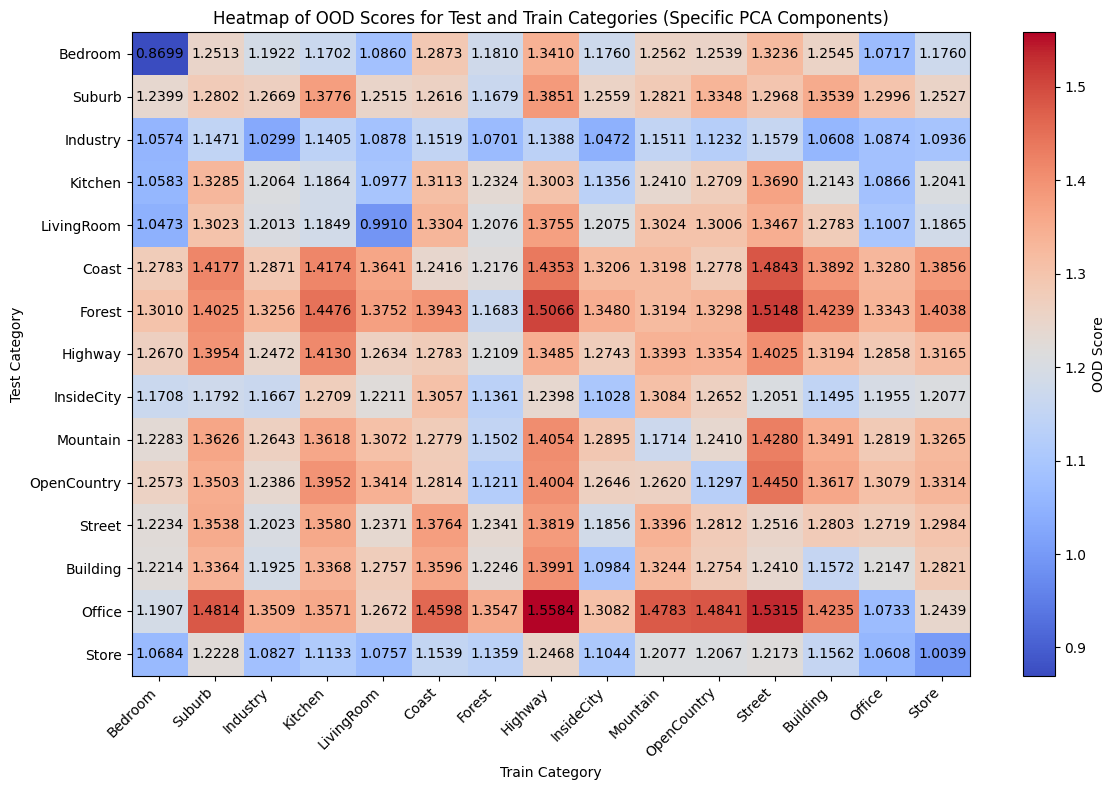

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lista de categorias disponíveis
categories = ['Bedroom', 'Suburb', 'Industry', 'Kitchen', 'LivingRoom', 'Coast', 'Forest', 
              'Highway', 'InsideCity', 'Mountain', 'OpenCountry', 'Street', 'Building', 
              'Office', 'Store']

# Inicializar uma matriz vazia para armazenar os OOD scores
ood_score_matrix = np.full((len(categories), len(categories)), np.nan)

# Preencher a matriz com os OOD scores calculados
for i, test_category in enumerate(categories):
    for j, train_category in enumerate(categories):
        key = f"{test_category}_on_{train_category}"
        if key in mean_ood_scores:
            ood_score_matrix[i, j] = mean_ood_scores[key]

# Criar um DataFrame a partir da matriz de OOD scores para facilitar o plot
ood_score_df = pd.DataFrame(ood_score_matrix, index=categories, columns=categories)

# Plotar o heatmap usando apenas matplotlib
fig, ax = plt.subplots(figsize=(12, 8))

# Criar o heatmap com imshow
cax = ax.imshow(ood_score_df, cmap="coolwarm", aspect="auto")

# Adicionar os valores na matriz
for i in range(len(categories)):
    for j in range(len(categories)):
        value = ood_score_matrix[i, j]
        if not np.isnan(value):
            ax.text(j, i, f'{value:.4f}', ha='center', va='center', color='black')

# Configurar os eixos
ax.set_xticks(np.arange(len(categories)))
ax.set_yticks(np.arange(len(categories)))
ax.set_xticklabels(categories, rotation=45, ha="right")
ax.set_yticklabels(categories)

# Adicionar título e rótulos dos eixos
ax.set_title('Heatmap of OOD Scores for Test and Train Categories (Specific PCA Components)')
ax.set_xlabel('Train Category')
ax.set_ylabel('Test Category')

# Adicionar a barra de cores (colorbar)
fig.colorbar(cax, ax=ax, label='OOD Score')

# Ajustar layout
plt.tight_layout()

# Mostrar o heatmap
plt.show()
